In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from exploratory_sncosmo_analysis_functions import plot_sncosmo_param_hist, plot_param_hist_with_models, remove_outliers, merge_by_object_id, get_bump_nb_pairs, scatterplot_2x4_pairs, scatterplot_2x4_pairs_interactive, scatterplot_2x2_pairs_interactive, remove_outliers_with_object_ids, clean_triplets


sncosmo_file_path = "/Users/kai/Desktop/Coding/Python/Swinburne/SALT2_analysis/data/raw/general_results.csv"
sncosmo_pdf = pd.read_csv(sncosmo_file_path)

flux_fits_file_path = "/Users/kai/Desktop/Coding/Python/Swinburne/SALT2_analysis/data/raw/flux_fits_data.csv"
flux_fits_pdf = pd.read_csv(flux_fits_file_path)
flux_fits_pdf_unique = flux_fits_pdf.drop_duplicates(subset="object id")

In [4]:
eval_arr   = sncosmo_pdf[["ndof", "min chi2", "p-val"]].to_numpy()
params_arr = sncosmo_pdf[["z", "t0", "x0", "x1", "c"]].to_numpy()
ndof, min_chi2, p_vals = eval_arr.T
reduced_chi2 = min_chi2 / ndof
z, t0, x0, x1, c = params_arr.T

/var/folders/nh/74hv8v0x06jc83ddd62dz8mh0000gn/T/ipykernel_81486/3377123334.py:4: RuntimeWarning:

divide by zero encountered in divide



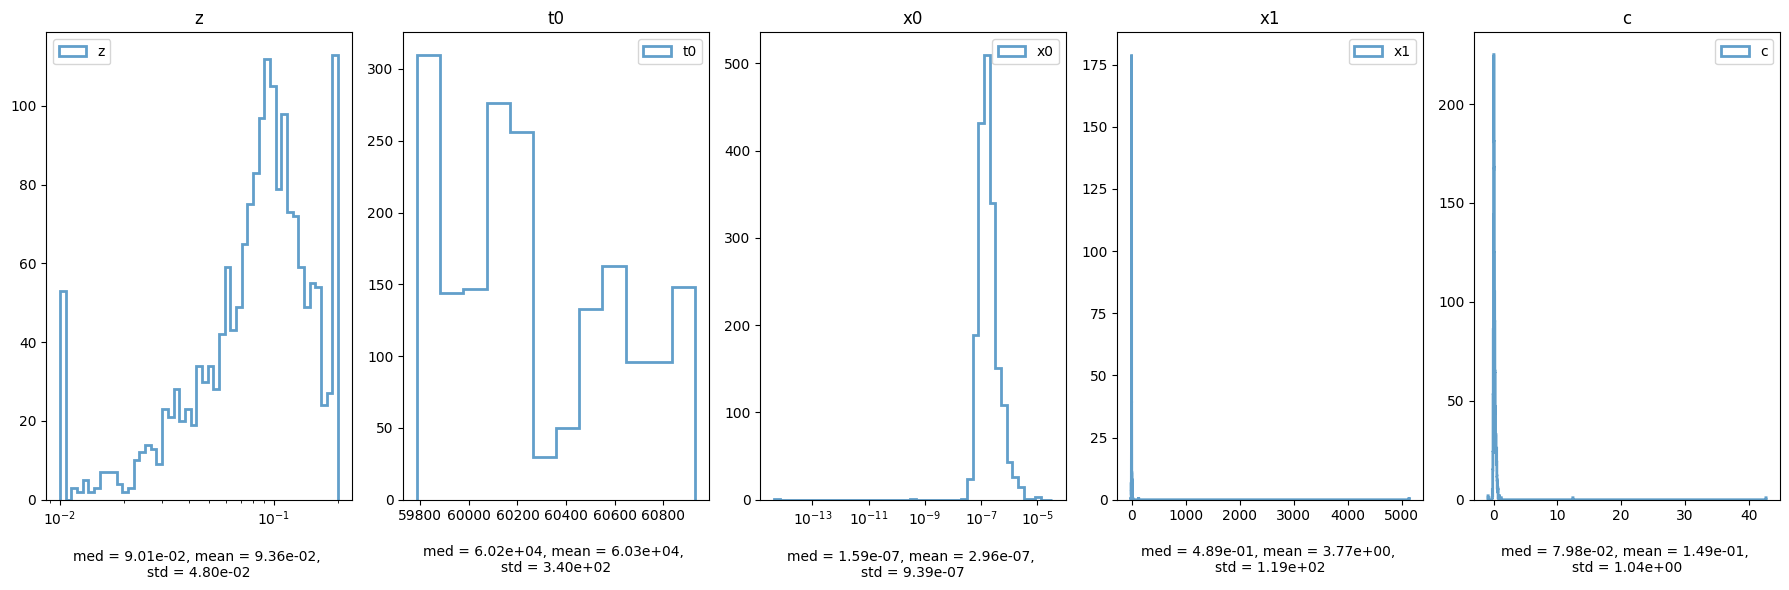

In [5]:
plot_sncosmo_param_hist([
    (z, "z", True, False, None),
    (t0, "t0", False, False, None),
    (x0, "x0", True, False, None),
    (x1, "x1", False, False, None),
    (c, "c", False, False, None)
], 18, 6)

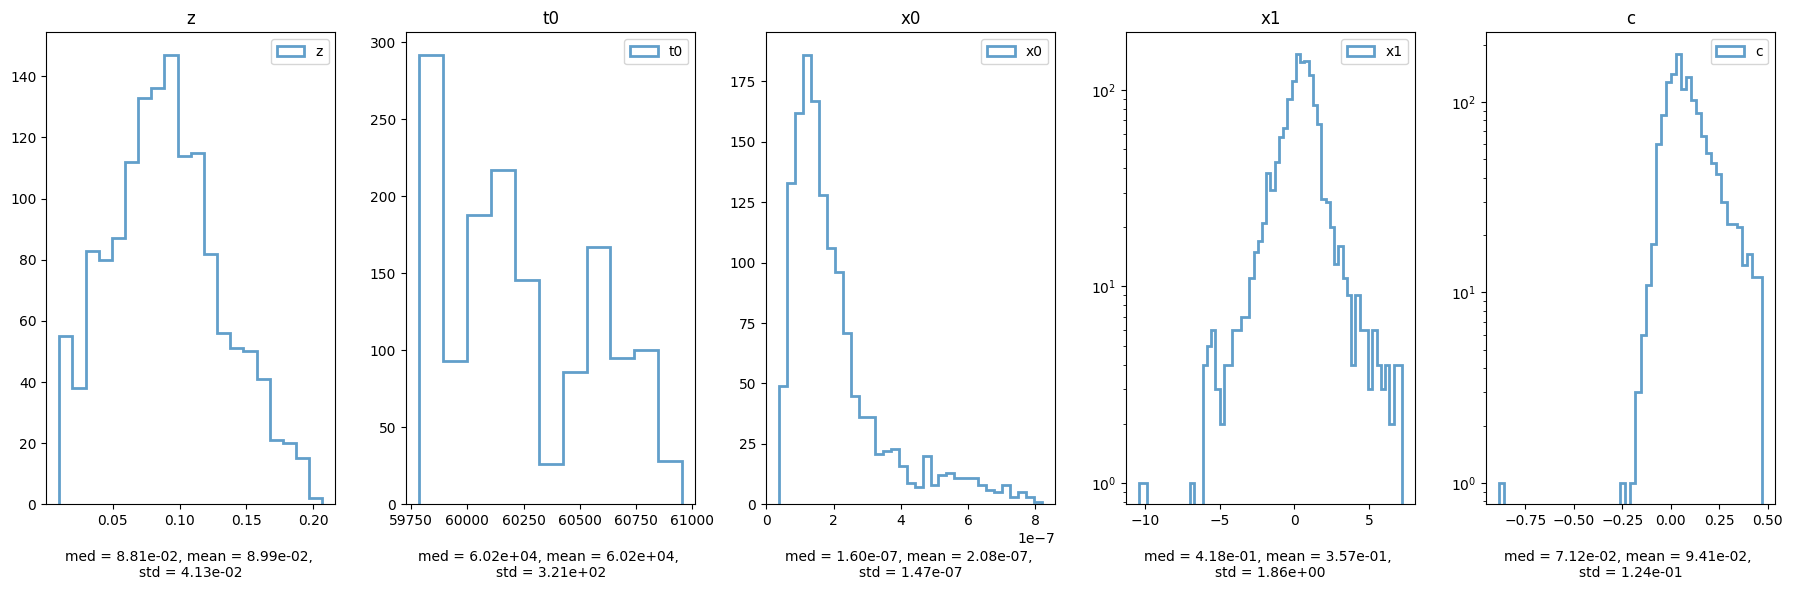

In [6]:
z, t0, x0, x1, c = zip(*remove_outliers(params_arr))

mb = -2.5*np.log(x0)

plot_sncosmo_param_hist([
    (z, "z", False, False, None),
    (t0, "t0", False, False, None),
    (x0, "x0", False, False, None),
    (x1, "x1", False, True, None),
    (c, "c", False, True, None)
], 18, 6)

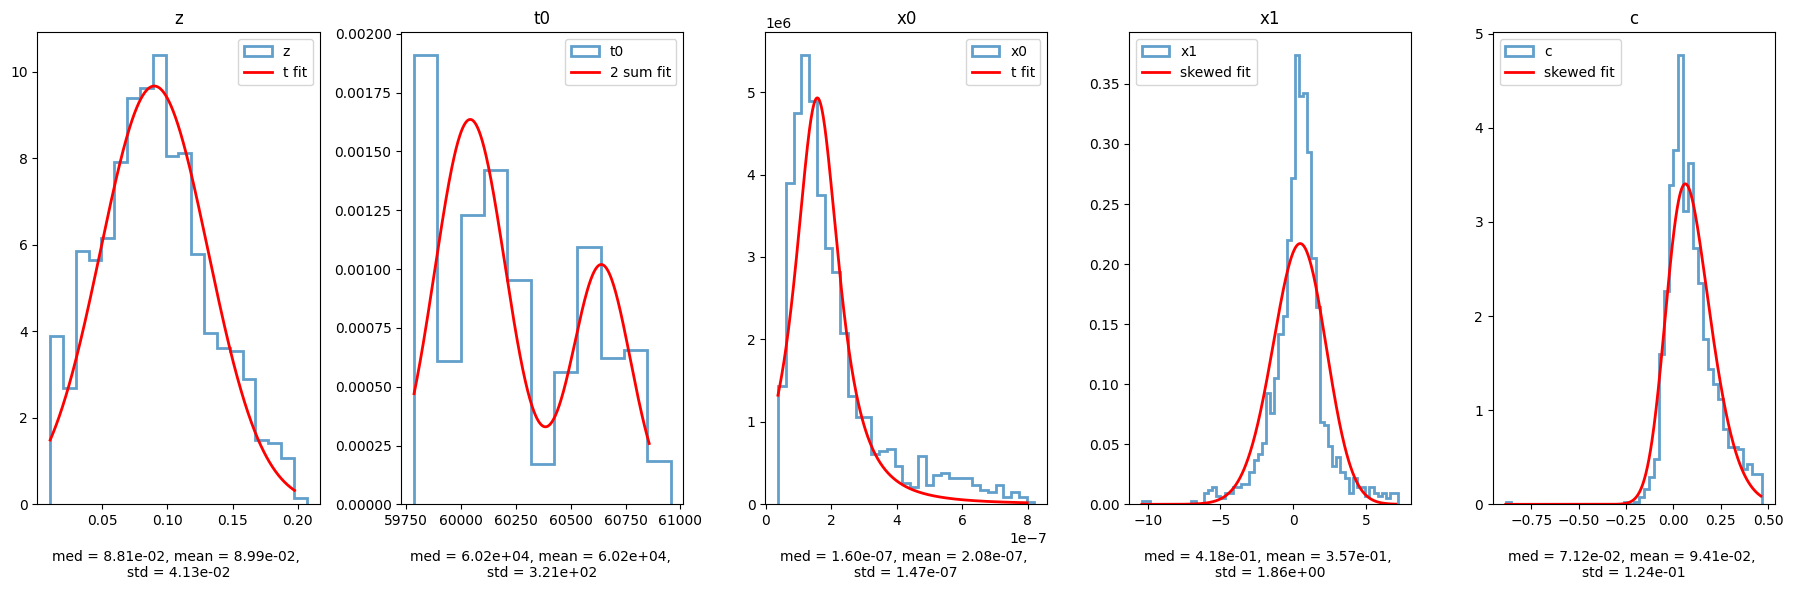

In [7]:
"""
Options for distributions:
- Skewed Gaussian distribution (skewed)
- Sum of two gaussians distribtions (2 sum)
- Student's t distribution (t)
- Laplacian distribution (laplace)
- Generalized normal distribtuion (gennorm)
"""
plot_param_hist_with_models([
    (z, "z", False, False, "t"),
    (t0, "t0", False, False, "2 sum"),
    (x0, "x0", False, False, "t"),
    (x1, "x1", False, False, "skewed"),
    (c, "c", False, False, "skewed")
], 18, 6)

Refit all the type Ias with measured redshift (TNS) and plot x1 and c values. Download data. Also stratify by bumps

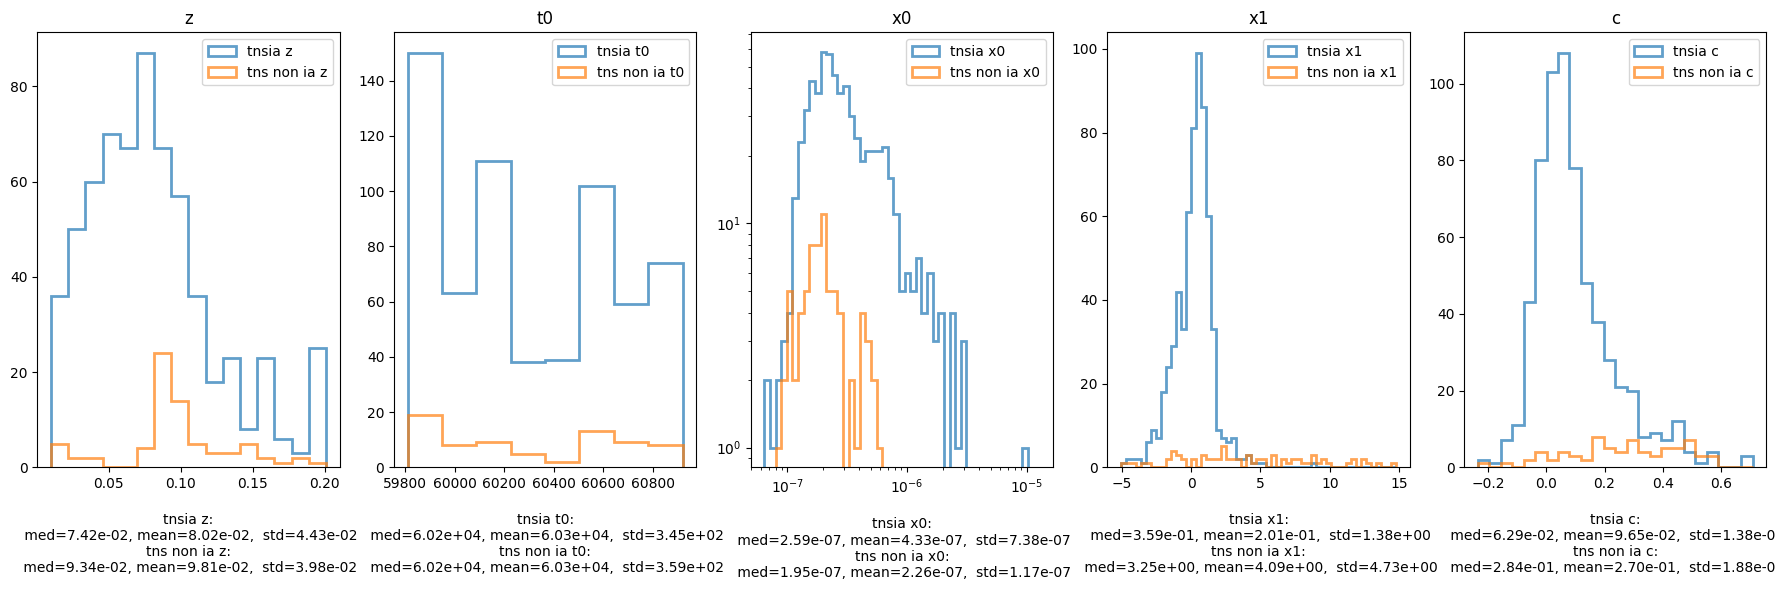

In [8]:
# Looking at parameter distributions of TNS classified Ias vs non Ias

ia_types = {'SN Ia', 'SN Ia-91T-like', 'SN Iax[02cx-like]', 'SN Ia-pec'}

merged_df = pd.merge(
    flux_fits_pdf_unique[["object id", "TNS classified"]],
    sncosmo_pdf[["object id", "z", "x0", "x1", "t0", "c"]],
    on="object id",
    how="inner"
)

maskTNSIa = merged_df["TNS classified"].isin(ia_types)
maskNonIaTNS = merged_df["TNS classified"].notna() & ~merged_df["TNS classified"].isin(ia_types)

merged_tnsia = merged_df[maskTNSIa]
merged_tns_nonia = merged_df[maskNonIaTNS]

tnsia_params = merged_tnsia[["z", "t0", "x0", "x1", "c"]].to_numpy()
tnsia_z, tnsia_t0, tnsia_x0, tnsia_x1, tnsia_c = zip(*tnsia_params)
nop_tnsia_z, nop_tnsia_t0, nop_tnsia_x0, nop_tnsia_x1, nop_tnsia_c = zip(*remove_outliers(tnsia_params))

no_tnsia_params = merged_tns_nonia[["z", "t0", "x0", "x1", "c"]].to_numpy()
nb_z, nb_t0, bn_x0, nb_x1, nbc = zip(*no_tnsia_params)
tns_nonia_z, tns_nonia_t0, tns_nonia_x0, tns_nonia_x1, tns_nonia_c = zip(*remove_outliers(no_tnsia_params))

tnsia_pairs = [
    [tnsia_z, tns_nonia_z, ["tnsia z", "tns non ia z"], "z", False, False, None],
    [tnsia_t0, tns_nonia_t0, ["tnsia t0", "tns non ia t0"], "t0", False, False, None],
    [tnsia_x0, tns_nonia_x0, ["tnsia x0", "tns non ia x0"], "x0", True, True, None],
    [tnsia_x1, tns_nonia_x1, ["tnsia x1", "tns non ia x1"], "x1", False, False, None],
    [tnsia_c, tns_nonia_c, ["tnsia c", "tns non ia c"], "c", False, False, None]
]

plot_sncosmo_param_hist(tnsia_pairs, 18, 6, data_groups=True, nrows=1, ncols=5)

Plot x1 ranges -3, 3, c ranges -0.3, 0.3. Check subtypes of ones that look like Ia (in those ranges). Plot color uncertanties for contaminants.

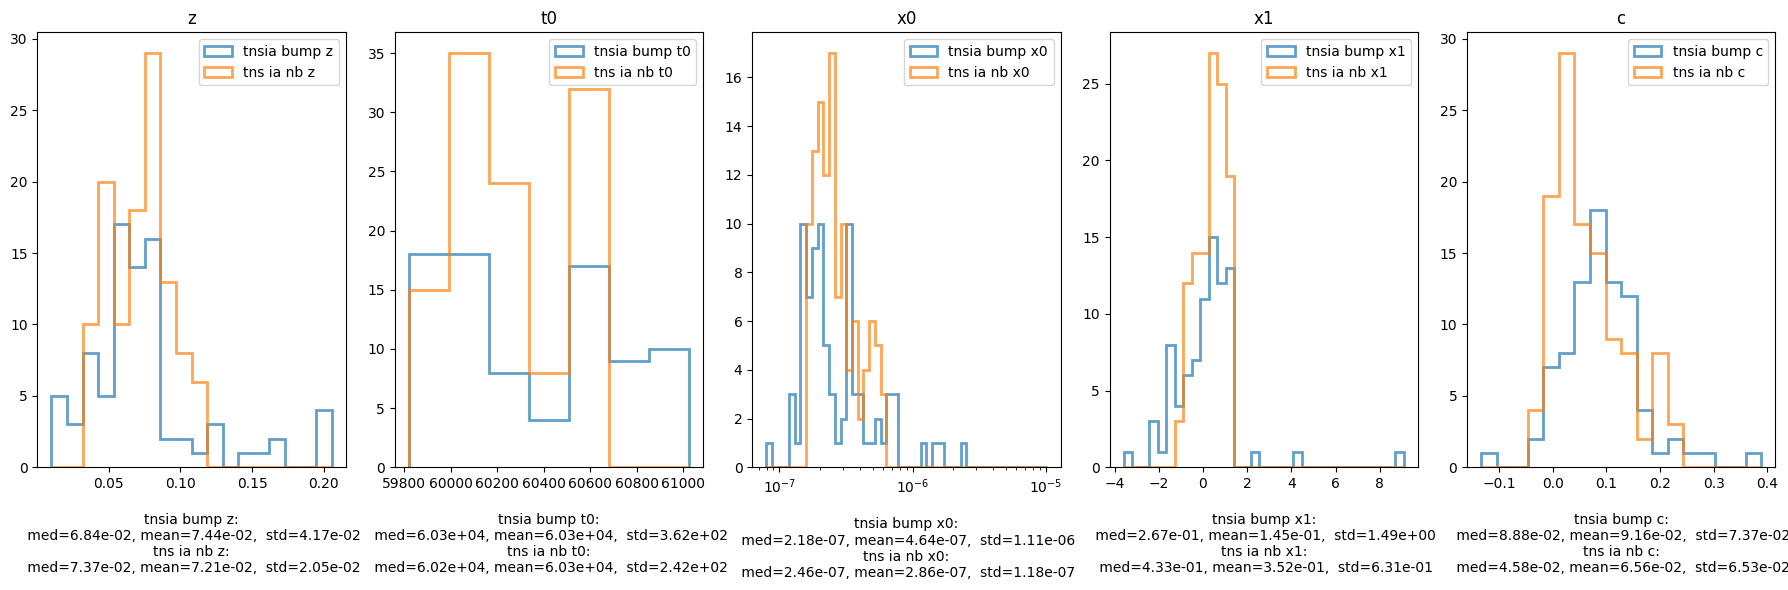

In [29]:
# Looking at parameter distributions of TNS classified Ias vs Ias with bumps

ia_types = {'SN Ia', 'SN Ia-91T-like', 'SN Iax[02cx-like]', 'SN Ia-pec'}

merged_df = pd.merge(
    flux_fits_pdf_unique[["object id", "TNS classified", "color change"]],
    sncosmo_pdf[["object id", "z", "x0", "x1", "t0", "c"]],
    on="object id",
    how="inner"
)
percentiles = [15, 85]
maskTNSIa = merged_df["TNS classified"].isin(ia_types)
maskNonIaTNS = merged_df["TNS classified"].notna() & ~merged_df["TNS classified"].isin(ia_types)
maskBump = merged_df["color change"] == 'bump'

merged_tnsia_bump = merged_df[maskTNSIa & maskBump] 
merged_tns_nonia_nb = merged_df[maskTNSIa & ~maskBump]

tnsia_params = merged_tnsia_bump[["z", "t0", "x0", "x1", "c"]].to_numpy()
tnsia_z, tnsia_t0, tnsia_x0, tnsia_x1, tnsia_c = zip(*tnsia_params)
nop_tnsia_z, nop_tnsia_t0, nop_tnsia_x0, nop_tnsia_x1, nop_tnsia_c = zip(*remove_outliers(tnsia_params, *percentiles))

no_tnsia_params = merged_tns_nonia_nb[["z", "t0", "x0", "x1", "c"]].to_numpy()
nb_z, nb_t0, bn_x0, nb_x1, nbc = zip(*no_tnsia_params)
tns_nonia_z, tns_nonia_t0, tns_nonia_x0, tns_nonia_x1, tns_nonia_c = zip(*remove_outliers(no_tnsia_params, *percentiles))

tnsia_pairs = [
    [tnsia_z, tns_nonia_z, ["tnsia bump z", "tns ia nb z"], "z", False, False, None],
    [tnsia_t0, tns_nonia_t0, ["tnsia bump t0", "tns ia nb t0"], "t0", False, False, None],
    [tnsia_x0, tns_nonia_x0, ["tnsia bump x0", "tns ia nb x0"], "x0", True, False, None],
    [tnsia_x1, tns_nonia_x1, ["tnsia bump x1", "tns ia nb x1"], "x1", False, False, None],
    [tnsia_c, tns_nonia_c, ["tnsia bump c", "tns ia nb c"], "c", False, False, None]
]

plot_sncosmo_param_hist(tnsia_pairs, 18, 6, data_groups=True, nrows=1, ncols=5)

Want to see only redshift, color, stretch in above ranges, as well as sigma c (see if it says anything about bump). Do error in stretch (focus on contaminants)

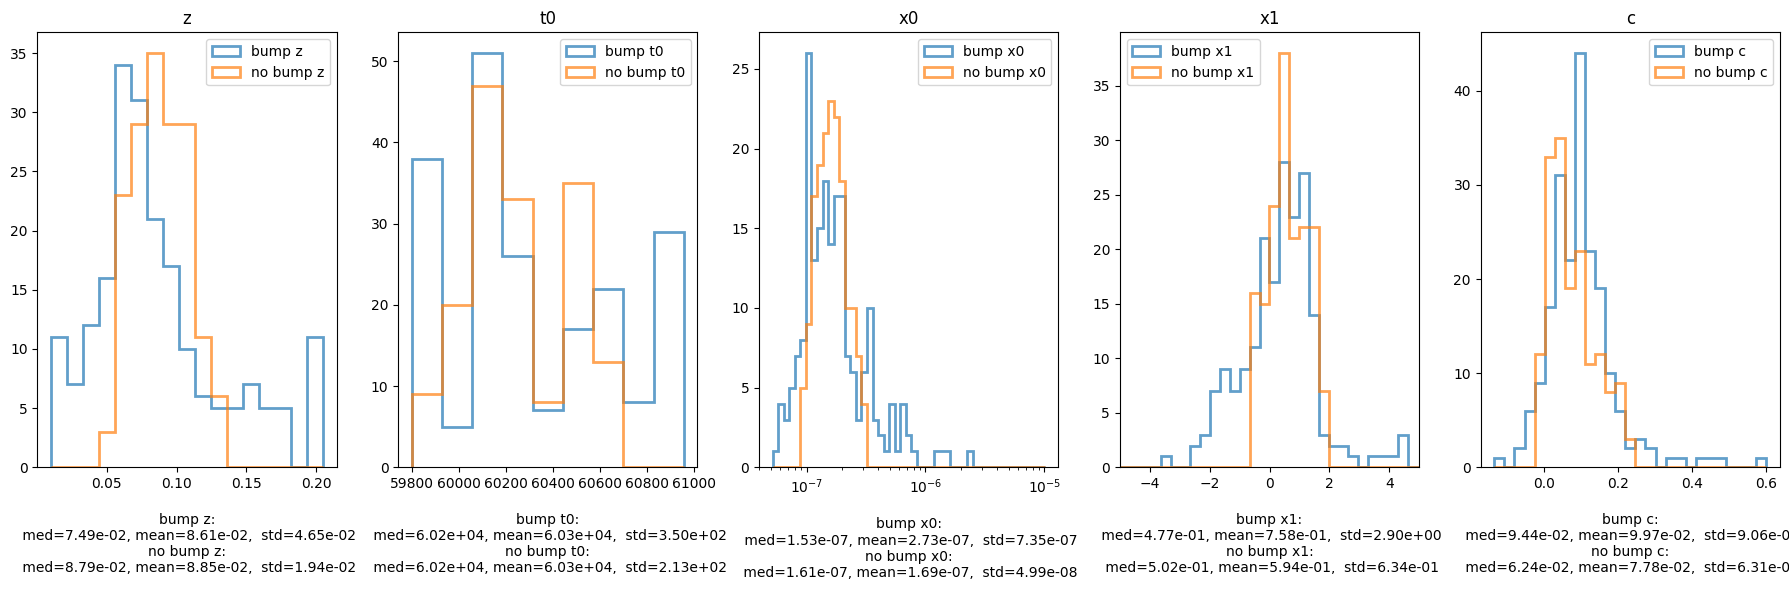

In [33]:
bump_ids = flux_fits_pdf_unique.loc[flux_fits_pdf_unique["color change"] == "bump", "object id"]

bump_sncosmo = sncosmo_pdf[sncosmo_pdf["object id"].isin(bump_ids)]
no_bump_sncosmo = sncosmo_pdf[~sncosmo_pdf["object id"].isin(bump_ids)]
percentiles = [20, 80]
bump_params = bump_sncosmo[["z", "t0", "x0", "x1", "c"]].to_numpy()
bump_z, bump_t0, bump_x0, bump_x1, bump_c = zip(*bump_params)
nop_bump_z, nop_bump_t0, nop_bump_x0, nop_bump_x1, nop_bump_c = zip(*remove_outliers(bump_params, *percentiles))

no_bump_params = no_bump_sncosmo[["z", "t0", "x0", "x1", "c"]].to_numpy()
nb_z, nb_t0, bn_x0, nb_x1, nbc = zip(*no_bump_params)
nop_nb_z, nop_nb_t0, nop_nb_x0, nop_nb_x1, nop_nb_c = zip(*remove_outliers(no_bump_params, *percentiles))

bump_pairs = [
    [bump_z, nop_nb_z, ["bump z", "no bump z"], "z", False, False, None],
    [bump_t0, nop_nb_t0, ["bump t0", "no bump t0"], "t0", False, False, None],
    [bump_x0, nop_nb_x0, ["bump x0", "no bump x0"], "x0", True, False, None],
    [bump_x1, nop_nb_x1, ["bump x1", "no bump x1"], "x1", False, False, (-5, 5)],
    [bump_c, nop_nb_c, ["bump c", "no bump c"], "c", False, False, None]
]

plot_sncosmo_param_hist(bump_pairs, 18, 6, data_groups=True, nrows=1, ncols=5)

Put y scale in log

In [11]:
sig_bump_cc_g, sig_nb_cc_g, sig_bump_cc_r, sig_nb_cc_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='c', fluxfit_col='c', 
    model_name='sigmoid'
)

sig_bump_g_c_vals, sig_bump_g_curv_vals = sig_bump_cc_g['sncosmo_c'], sig_bump_cc_g['fluxfit_c']
sig_nb_g_c_vals, sig_nb_g_curv_vals = sig_nb_cc_g['sncosmo_c'], sig_nb_cc_g['fluxfit_c']
sig_bump_r_c_vals, sig_bump_r_curv_vals = sig_bump_cc_r['sncosmo_c'], sig_bump_cc_r['fluxfit_c']
sig_nb_r_c_vals, sig_nb_r_curv_vals = sig_nb_cc_r['sncosmo_c'], sig_nb_cc_r['fluxfit_c']

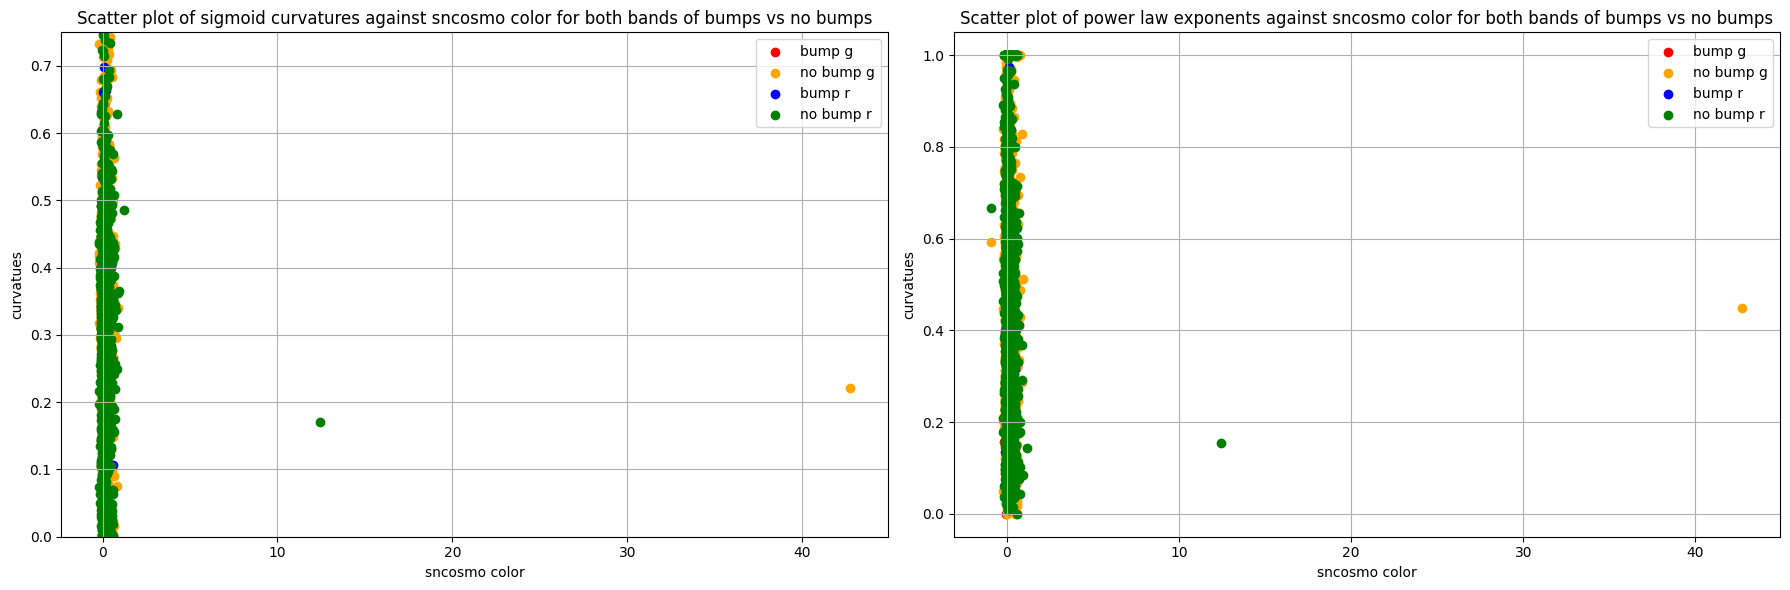

In [12]:
sig_bump_cc_data = [
    [sig_bump_g_c_vals, sig_bump_g_curv_vals, 'bump g'],
    [sig_nb_g_c_vals, sig_nb_g_curv_vals, 'no bump g'],
    [sig_bump_r_c_vals, sig_bump_r_curv_vals, 'bump r'],
    [sig_nb_r_c_vals, sig_nb_r_curv_vals, 'no bump r']
]
pow_bump_g, pow_nb_g, pow_bump_r, pow_nb_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='c', fluxfit_col='c', 
    model_name='power'
)

pow_bump_g_c_vals, pow_bump_g_curv_vals = pow_bump_g['sncosmo_c'], pow_bump_g['fluxfit_c']
pow_nb_g_c_vals, pow_nb_g_curv_vals = pow_nb_g['sncosmo_c'], pow_nb_g['fluxfit_c']
pow_bump_r_c_vals, pow_bump_r_curv_vals = pow_bump_r['sncosmo_c'], pow_bump_r['fluxfit_c']
pow_nb_r_c_vals, pow_nb_r_curv_vals = pow_nb_r['sncosmo_c'], pow_nb_r['fluxfit_c']

pow_bump_cc_data = [
    [pow_bump_g_c_vals, pow_bump_g_curv_vals, 'bump g'],
    [pow_nb_g_c_vals, pow_nb_g_curv_vals, 'no bump g'],
    [pow_bump_r_c_vals, pow_bump_r_curv_vals, 'bump r'],
    [pow_nb_r_c_vals, pow_nb_r_curv_vals, 'no bump r']
]

pow_title = "Scatter plot of power law exponents against sncosmo color for both bands of bumps vs no bumps"
sig_title = "Scatter plot of sigmoid curvatures against sncosmo color for both bands of bumps vs no bumps"
scatterplot_2x4_pairs(
    sig_bump_cc_data, pow_bump_cc_data, "sncosmo color", "curvatues", 
    titles=(sig_title, pow_title), ylims=((0, 0.75), None)
)

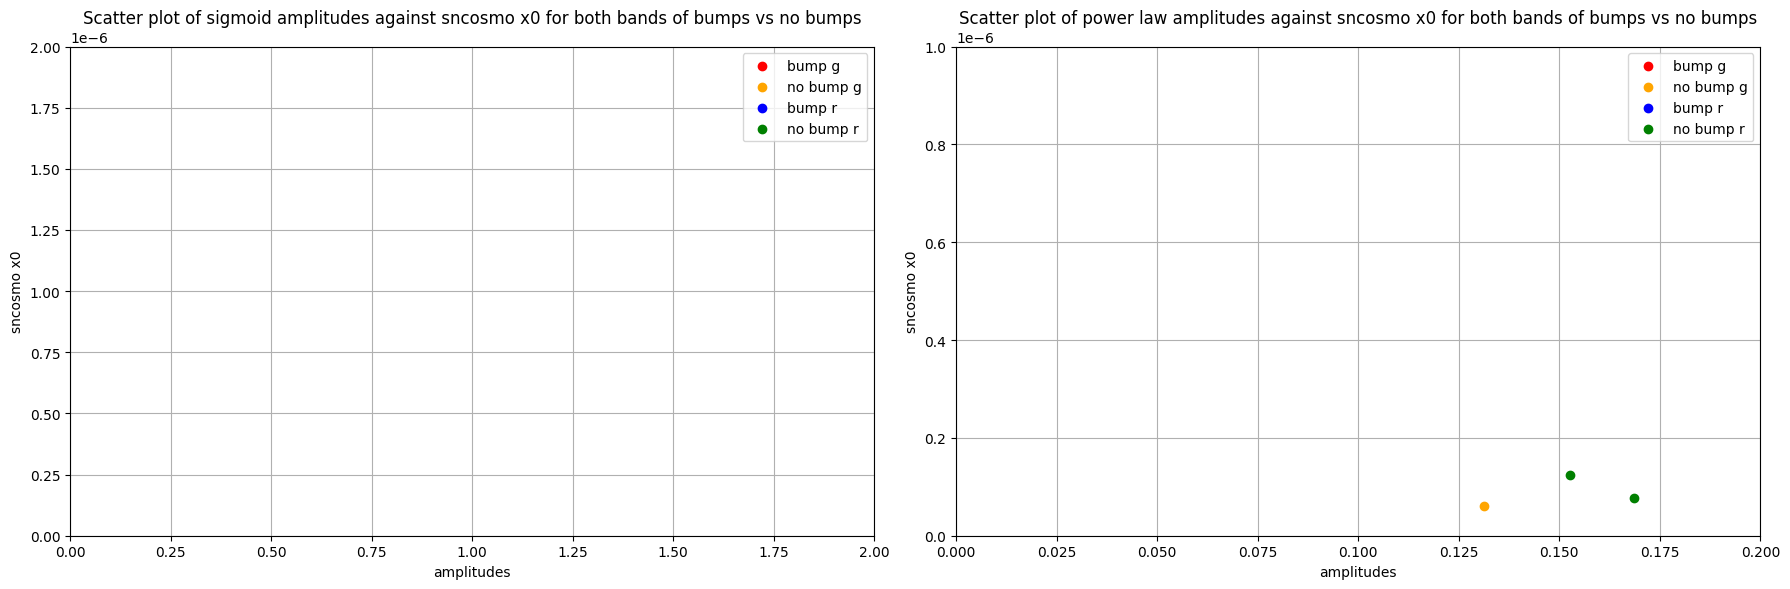

In [13]:
sig_bump_ax0_g, sig_nb_ax0_g, sig_bump_ax0_r, sig_nb_ax0_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='x0', fluxfit_col='a', 
    model_name='sigmoid'
)

sig_bump_g_x0_vals, sig_bump_g_a_vals = sig_bump_ax0_g['sncosmo_x0'], sig_bump_ax0_g['fluxfit_a']
sig_nb_g_x0_vals, sig_nb_g_a_vals = sig_nb_ax0_g['sncosmo_x0'], sig_nb_ax0_g['fluxfit_a']
sig_bump_r_x0_vals, sig_bump_r_a_vals = sig_bump_ax0_r['sncosmo_x0'], sig_bump_ax0_r['fluxfit_a']
sig_nb_r_x0_vals, sig_nb_r_a_vals = sig_nb_ax0_r['sncosmo_x0'], sig_nb_ax0_r['fluxfit_a']

sig_bump_ax0_data = [
    [sig_bump_g_a_vals, sig_bump_g_x0_vals, 'bump g'],
    [sig_nb_g_a_vals, sig_nb_g_x0_vals, 'no bump g'],
    [sig_bump_r_a_vals, sig_bump_r_x0_vals, 'bump r'],
    [sig_nb_r_a_vals, sig_nb_r_x0_vals, 'no bump r']
]

pow_bump_ax0_g, pow_nb_ax0_g, pow_bump_ax0_r, pow_nb_ax0_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='x0', fluxfit_col='a', 
    model_name='power'
)

pow_bump_g_x0_vals, pow_bump_g_a_vals = pow_bump_ax0_g['sncosmo_x0'], pow_bump_ax0_g['fluxfit_a']
pow_nb_g_x0_vals, pow_nb_g_a_vals = pow_nb_ax0_g['sncosmo_x0'], pow_nb_ax0_g['fluxfit_a']
pow_bump_r_x0_vals, pow_bump_r_a_vals = pow_bump_ax0_r['sncosmo_x0'], pow_bump_ax0_r['fluxfit_a']
pow_nb_r_x0_vals, pow_nb_r_a_vals = pow_nb_ax0_r['sncosmo_x0'], pow_nb_ax0_r['fluxfit_a']

pow_bump_ax0_data = [
    [pow_bump_g_a_vals, pow_bump_g_x0_vals, 'bump g'],
    [pow_nb_g_a_vals, pow_nb_g_x0_vals, 'no bump g'],
    [pow_bump_r_a_vals, pow_bump_r_x0_vals, 'bump r'],
    [pow_nb_r_a_vals, pow_nb_r_x0_vals, 'no bump r']
]


sig_title = "Scatter plot of sigmoid amplitudes against sncosmo x0 for both bands of bumps vs no bumps"
pow_title = "Scatter plot of power law amplitudes against sncosmo x0 for both bands of bumps vs no bumps"
scatterplot_2x4_pairs(
    sig_bump_ax0_data, pow_bump_ax0_data, "amplitudes",  "sncosmo x0",
    titles=(sig_title, pow_title), xlims=((0, 2), (0, 0.2)), ylims=((0, 0.2E-5), (0, 1E-6))
)

In [14]:
sig_bump_ax0_obj_ids = [
    sig_bump_ax0_g['object id'].values,
    sig_nb_ax0_g['object id'].values,
    sig_bump_ax0_r['object id'].values,
    sig_nb_ax0_r['object id'].values
]

pow_bump_ax0_obj_ids = [
    pow_bump_ax0_g['object id'].values,
    pow_nb_ax0_g['object id'].values,
    pow_bump_ax0_r['object id'].values,
    pow_nb_ax0_r['object id'].values
]

sig_title = "sig a vs sncosmo x0"
pow_title = "pow a vs sncosmo x0"
# scatterplot_2x4_pairs_interactive(
#     sig_bump_ax0_data, pow_bump_ax0_data, sig_bump_ax0_obj_ids, pow_bump_ax0_obj_ids, "amplitudes", 
#     "sncosmo x0", xlims=((0, 2), (0, 0.2)), ylims=((0, 0.2E-5), (0, 1E-6)), titles=(sig_title, pow_title)
# )

g-band | z ∈ [0.01, 0.06): m = 1.6085e-09 ± 1.43e-11, c = -2.3345e-08 ± 5.17e-09
g-band | z ∈ [0.06, 0.09): m = 1.6057e-09 ± 9.44e-12, c = -3.3763e-08 ± 2.33e-09
g-band | z ∈ [0.09, 0.20): m = 1.4963e-09 ± 3.87e-11, c = -2.2792e-08 ± 7.73e-09
r-band | z ∈ [0.01, 0.06): m = 1.1497e-09 ± 1.90e-11, c = 7.9165e-08 ± 7.10e-09
r-band | z ∈ [0.06, 0.09): m = 1.6658e-09 ± 5.70e-11, c = -3.3916e-08 ± 1.21e-08
r-band | z ∈ [0.09, 0.20): m = 1.2036e-09 ± 4.76e-11, c = 3.6047e-08 ± 8.24e-09


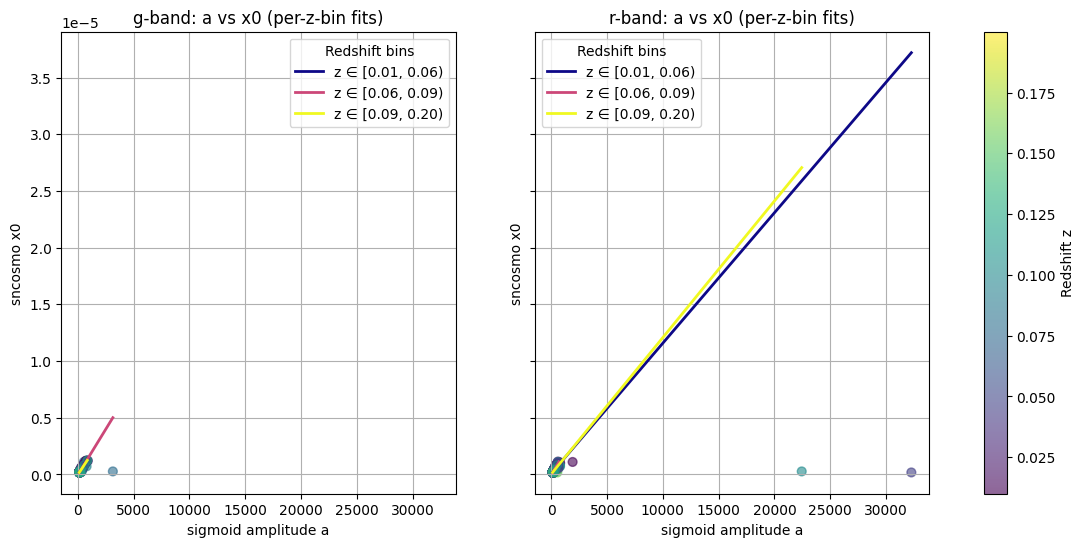

In [15]:
def linear_fit(x, m, c):
    return m * x + c

flux_sig_g = flux_fits_pdf[
    (flux_fits_pdf["model"] == "sigmoid") &
    (flux_fits_pdf["filter"] == "g")
]

flux_sig_r = flux_fits_pdf[
    (flux_fits_pdf["model"] == "sigmoid") &
    (flux_fits_pdf["filter"] == "r")
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

for ax, flux_sig, band in zip(
    axes,
    [flux_sig_g, flux_sig_r],
    ["g", "r"]
):
    sig_merged = pd.merge(
        sncosmo_pdf,
        flux_sig,
        on="object id",
        how="inner"
    )

    mask_finite = np.isfinite(sig_merged["sig x0"]) & np.isfinite(sig_merged["sig a"])
    sig_merged = sig_merged[mask_finite]

    sig_a_low, sig_a_high   = sig_merged["a"].quantile([0.4, 0.96])
    sig_x0_low, sig_x0_high = sig_merged["x0"].quantile([0.4, 0.96])

    mask_outliers = (
        (sig_merged["a"]  >= sig_a_low) & (sig_merged["a"]  <= sig_a_high) &
        (sig_merged["x0"] >= sig_x0_low) & (sig_merged["x0"] <= sig_x0_high)
    )

    ax_clean = sig_merged[mask_outliers].reset_index(drop=True)

    sc = ax.scatter(
        ax_clean["a"], 
        ax_clean["x0"], 
        c=ax_clean["z"],  
        cmap="viridis",           
        s=40,
        alpha=0.6
    )

    n_bins = 3
    z_bins = np.quantile(ax_clean["z"], np.linspace(0, 1, n_bins+1))
    cmap_bins = plt.get_cmap("plasma", n_bins)
    lines = []

    for i in range(n_bins):
        zmin, zmax = z_bins[i], z_bins[i+1]
        mask_bin = (ax_clean["z"] >= zmin) & (ax_clean["z"] < zmax)
        data_bin = ax_clean[mask_bin]
        if len(data_bin) < 3:
            continue  

        m0 = (np.max(data_bin["x0"]) - np.min(data_bin["x0"])) / (
            np.max(data_bin["a"]) - np.min(data_bin["a"])
        )
        c0 = 0
        params_bin, cov_bin = curve_fit(
            linear_fit,
            data_bin["a"],
            data_bin["x0"],
            sigma=data_bin["sig a"],
            p0=[m0, c0]
        )
        m_bin, c_bin = params_bin
        perr = np.sqrt(np.diag(cov_bin))

        a_vals = np.linspace(np.min(data_bin["a"]), np.max(data_bin["a"]), 500)
        fit_vals = linear_fit(a_vals, m_bin, c_bin)
        color_bin = cmap_bins(i)

        ax.plot(
            a_vals, fit_vals,
            color=color_bin,
            lw=2
        )

        lines.append(Line2D([0], [0], color=color_bin, lw=2,
                            label=f"z ∈ [{zmin:.2f}, {zmax:.2f})"))

        print(f"{band}-band | z ∈ [{zmin:.2f}, {zmax:.2f}): "
              f"m = {m_bin:.4e} ± {perr[0]:.2e}, "
              f"c = {c_bin:.4e} ± {perr[1]:.2e}")

    ax.set_xlabel("sigmoid amplitude a")
    ax.set_ylabel("sncosmo x0")
    ax.set_title(f"{band}-band: a vs x0 (per-z-bin fits)")
    ax.grid(True)

    ax.legend(handles=lines, title="Redshift bins")

cbar = fig.colorbar(sc, ax=axes.ravel().tolist())
cbar.set_label("Redshift z")

plt.show()


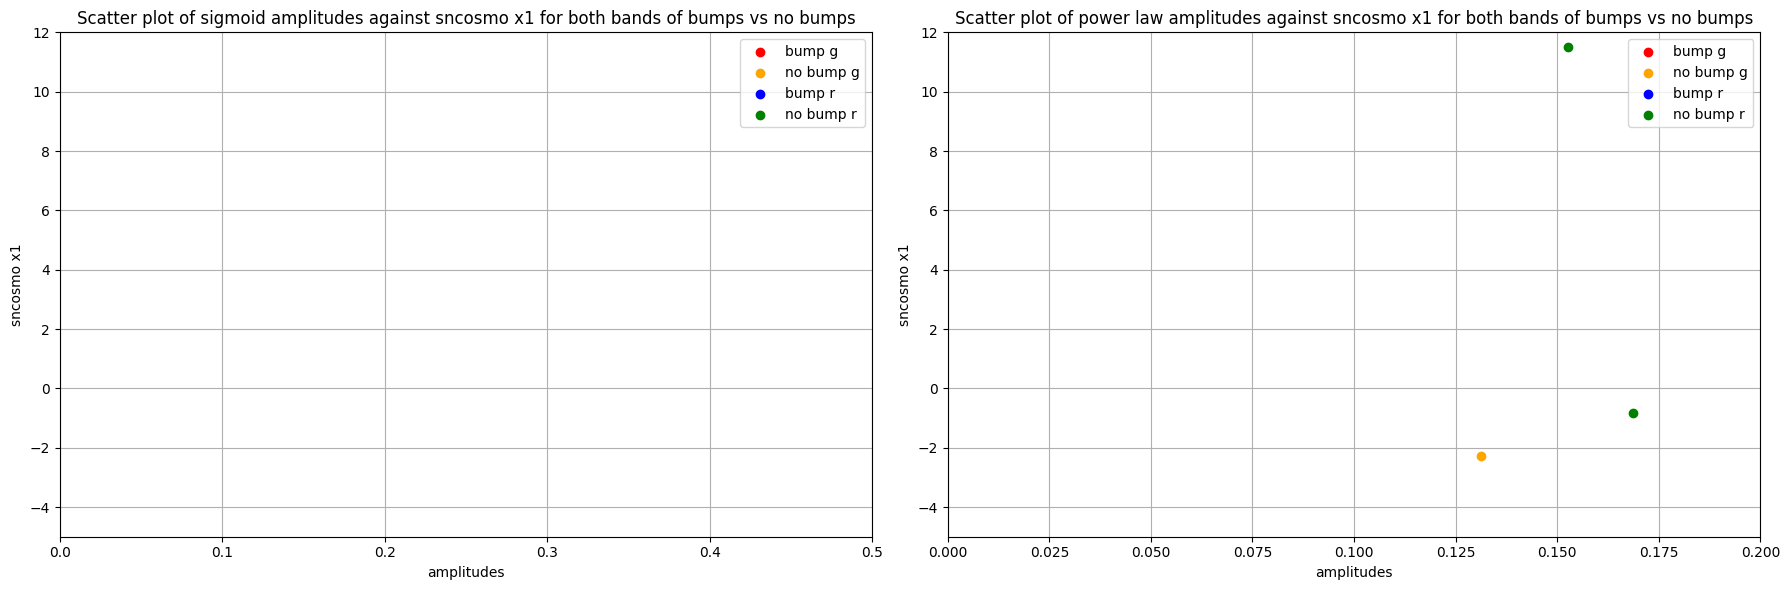

In [16]:
sig_bump_ax1_g, sig_nb_ax1_g, sig_bump_ax1_r, sig_nb_ax1_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='x1', fluxfit_col='a', 
    model_name='sigmoid'
)

sig_bump_g_x1_vals, sig_bump_g_a_vals = sig_bump_ax1_g['sncosmo_x1'], sig_bump_ax1_g['fluxfit_a']
sig_nb_g_x1_vals, sig_nb_g_a_vals = sig_nb_ax1_g['sncosmo_x1'], sig_nb_ax1_g['fluxfit_a']
sig_bump_r_x1_vals, sig_bump_r_a_vals = sig_bump_ax1_r['sncosmo_x1'], sig_bump_ax1_r['fluxfit_a']
sig_nb_r_x1_vals, sig_nb_r_a_vals = sig_nb_ax1_r['sncosmo_x1'], sig_nb_ax1_r['fluxfit_a']

sig_bump_ax1_data = [
    [sig_bump_g_a_vals, sig_bump_g_x1_vals, 'bump g'],
    [sig_nb_g_a_vals, sig_nb_g_x1_vals, 'no bump g'],
    [sig_bump_r_a_vals, sig_bump_r_x1_vals, 'bump r'],
    [sig_nb_r_a_vals, sig_nb_r_x1_vals, 'no bump r']
]

pow_bump_ax1_g, pow_nb_ax1_g, pow_bump_ax1_r, pow_nb_ax1_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='x1', fluxfit_col='a', 
    model_name='power'
)

pow_bump_g_x1_vals, pow_bump_g_a_vals = pow_bump_ax1_g['sncosmo_x1'], pow_bump_ax1_g['fluxfit_a']
pow_nb_g_x1_vals, pow_nb_g_a_vals = pow_nb_ax1_g['sncosmo_x1'], pow_nb_ax1_g['fluxfit_a']
pow_bump_r_x1_vals, pow_bump_r_a_vals = pow_bump_ax1_r['sncosmo_x1'], pow_bump_ax1_r['fluxfit_a']
pow_nb_r_x1_vals, pow_nb_r_a_vals = pow_nb_ax1_r['sncosmo_x1'], pow_nb_ax1_r['fluxfit_a']

pow_bump_ax1_data = [
    [pow_bump_g_a_vals, pow_bump_g_x1_vals, 'bump g'],
    [pow_nb_g_a_vals, pow_nb_g_x1_vals, 'no bump g'],
    [pow_bump_r_a_vals, pow_bump_r_x1_vals, 'bump r'],
    [pow_nb_r_a_vals, pow_nb_r_x1_vals, 'no bump r']
]

sig_title = "Scatter plot of sigmoid amplitudes against sncosmo x1 for both bands of bumps vs no bumps"
pow_title = "Scatter plot of power law amplitudes against sncosmo x1 for both bands of bumps vs no bumps"
scatterplot_2x4_pairs(
    sig_bump_ax1_data, pow_bump_ax1_data, "amplitudes",  "sncosmo x1",
    titles=(sig_title, pow_title), xlims=((0, 0.5), (0, 0.2)), ylims=((-5, 12), (-5, 12))
)

In [17]:
sig_bump_ax1_obj_ids = [
    sig_bump_ax1_g['object id'].values,
    sig_nb_ax1_g['object id'].values,
    sig_bump_ax1_r['object id'].values,
    sig_nb_ax1_r['object id'].values
]

pow_bump_ax1_obj_ids = [
    pow_bump_ax1_g['object id'].values,
    pow_nb_ax1_g['object id'].values,
    pow_bump_ax1_r['object id'].values,
    pow_nb_ax1_r['object id'].values
]

sig_title = "sig a vs sncosmo x1"
pow_title = "pow a vs sncosmo x1"
# scatterplot_2x4_pairs_interactive(
#     sig_bump_ax1_data, pow_bump_ax1_data, sig_bump_ax1_obj_ids, pow_bump_ax1_obj_ids, "amplitudes", 
#     "sncosmo x1", titles=(sig_title, pow_title),  xlims=((0, 0.5), (0, 0.2)), ylims=((-6, 12), (-5, 12))
# )

In [18]:
sig_bump_curvx1_g, sig_nb_curvx1_g, sig_bump_curvx1_r, sig_nb_curvx1_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf,
    sncosmo_col='x1', fluxfit_col='c',
    model_name='sigmoid'
)

sig_bump_g_x1, sig_bump_g_c, sig_bump_g_ids = remove_outliers_with_object_ids(
    sig_bump_curvx1_g['sncosmo_x1'], sig_bump_curvx1_g['fluxfit_c'], sig_bump_curvx1_g['object id'].values
)
sig_nb_g_x1, sig_nb_g_c, sig_nb_g_ids = remove_outliers_with_object_ids(
    sig_nb_curvx1_g['sncosmo_x1'], sig_nb_curvx1_g['fluxfit_c'], sig_nb_curvx1_g['object id'].values
)
sig_bump_r_x1, sig_bump_r_c, sig_bump_r_ids = remove_outliers_with_object_ids(
    sig_bump_curvx1_r['sncosmo_x1'], sig_bump_curvx1_r['fluxfit_c'], sig_bump_curvx1_r['object id'].values
)
sig_nb_r_x1, sig_nb_r_c, sig_nb_r_ids = remove_outliers_with_object_ids(
    sig_nb_curvx1_r['sncosmo_x1'], sig_nb_curvx1_r['fluxfit_c'], sig_nb_curvx1_r['object id'].values
)

sig_bump_curvx1_data = [
    [  
        [sig_bump_g_c, sig_bump_g_x1, 'sig bump g'],
        [sig_nb_g_c, sig_nb_g_x1, 'sig no bump g']
    ],
    [  
        [sig_bump_r_c, sig_bump_r_x1, 'sig bump r'],
        [sig_nb_r_c, sig_nb_r_x1, 'sig no bump r']
    ]
]

sig_bump_curvx1_obj_ids = [
    [sig_bump_g_ids, sig_nb_g_ids],
    [sig_bump_r_ids, sig_nb_r_ids]
]



pow_bump_curvx1_g, pow_nb_curvx1_g, pow_bump_curvx1_r, pow_nb_curvx1_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf,
    sncosmo_col='x1', fluxfit_col='c',
    model_name='power'
)


pow_bump_g_x1, pow_bump_g_c, pow_bump_g_ids = remove_outliers_with_object_ids(
    pow_bump_curvx1_g['sncosmo_x1'], pow_bump_curvx1_g['fluxfit_c'], pow_bump_curvx1_g['object id'].values
)
pow_nb_g_x1, pow_nb_g_c, pow_nb_g_ids = remove_outliers_with_object_ids(
    pow_nb_curvx1_g['sncosmo_x1'], pow_nb_curvx1_g['fluxfit_c'], pow_nb_curvx1_g['object id'].values
)
pow_bump_r_x1, pow_bump_r_c, pow_bump_r_ids = remove_outliers_with_object_ids(
    pow_bump_curvx1_r['sncosmo_x1'], pow_bump_curvx1_r['fluxfit_c'], pow_bump_curvx1_r['object id'].values
)
pow_nb_r_x1, pow_nb_r_c, pow_nb_r_ids = remove_outliers_with_object_ids(
    pow_nb_curvx1_r['sncosmo_x1'], pow_nb_curvx1_r['fluxfit_c'], pow_nb_curvx1_r['object id'].values
)


pow_bump_curvx1_data = [
    [  
        [pow_bump_g_c, pow_bump_g_x1, 'pow bump g'],
        [pow_nb_g_c, pow_nb_g_x1, 'pow no bump g']
    ],
    [  
        [pow_bump_r_c, pow_bump_r_x1, 'pow bump r'],
        [pow_nb_r_c, pow_nb_r_x1, 'pow no bump r']
    ]
]

pow_bump_curvx1_obj_ids = [
    [pow_bump_g_ids, pow_nb_g_ids],
    [pow_bump_r_ids, pow_nb_r_ids]
]

scatterplot_2x2_pairs_interactive(
    sig_bump_curvx1_data, pow_bump_curvx1_data, sig_bump_curvx1_obj_ids, pow_bump_curvx1_obj_ids, "sncosmox1", 
    "curvatures"
)

# sig_title = "Scatter plot of sigmoid curvatures against sncosmo x1 for both bands of bumps vs no bumps"
# pow_title = "Scatter plot of power law exponents against sncosmo x1 for both bands of bumps vs no bumps"
# scatterplot_2x4_pairs(
#     sig_bump_curvx1_data, pow_bump_curvx1_data, "c",  "sncosmo x1",
#     titles=(sig_title, pow_title), xlims=((0, 1), (0, 1)), ylims=((-5, 20), (-5, 20))
# )

sig bump g: slope=0.0008, intercept=0.3312, R²=0.0000, p=9.4358e-01, t=0.0709, N=127, sig=0.07σ
∆slope = 1.0943e-02, ∆intercept=9.0676e-03
sig no bump g: slope=-0.0233, intercept=0.3647, R²=0.0619, p=5.9414e-13, t=-7.3207, N=814, sig=7.20σ
∆slope = 3.1785e-03, ∆intercept=3.5454e-03
pow bump g: slope=-0.0113, intercept=0.4373, R²=0.0017, p=6.4386e-01, t=-0.4634, N=127, sig=0.46σ
∆slope = 2.4417e-02, ∆intercept=2.0500e-02
pow no bump g: slope=-0.0118, intercept=0.4695, R²=0.0032, p=7.4947e-02, t=-1.7827, N=1000, sig=1.78σ
∆slope = 6.6466e-03, ∆intercept=7.8909e-03
sig bump r: slope=-0.0178, intercept=0.3125, R²=0.0343, p=3.0179e-02, t=-2.1908, N=137, sig=2.17σ
∆slope = 8.1461e-03, ∆intercept=6.7602e-03
sig no bump r: slope=-0.0186, intercept=0.3193, R²=0.0470, p=3.7303e-11, t=-6.6966, N=912, sig=6.61σ
∆slope = 2.7820e-03, ∆intercept=3.2325e-03
pow bump r: slope=0.0378, intercept=0.3860, R²=0.0372, p=2.6100e-02, t=2.2503, N=133, sig=2.22σ
∆slope = 1.6801e-02, ∆intercept=1.4167e-02
pow no 

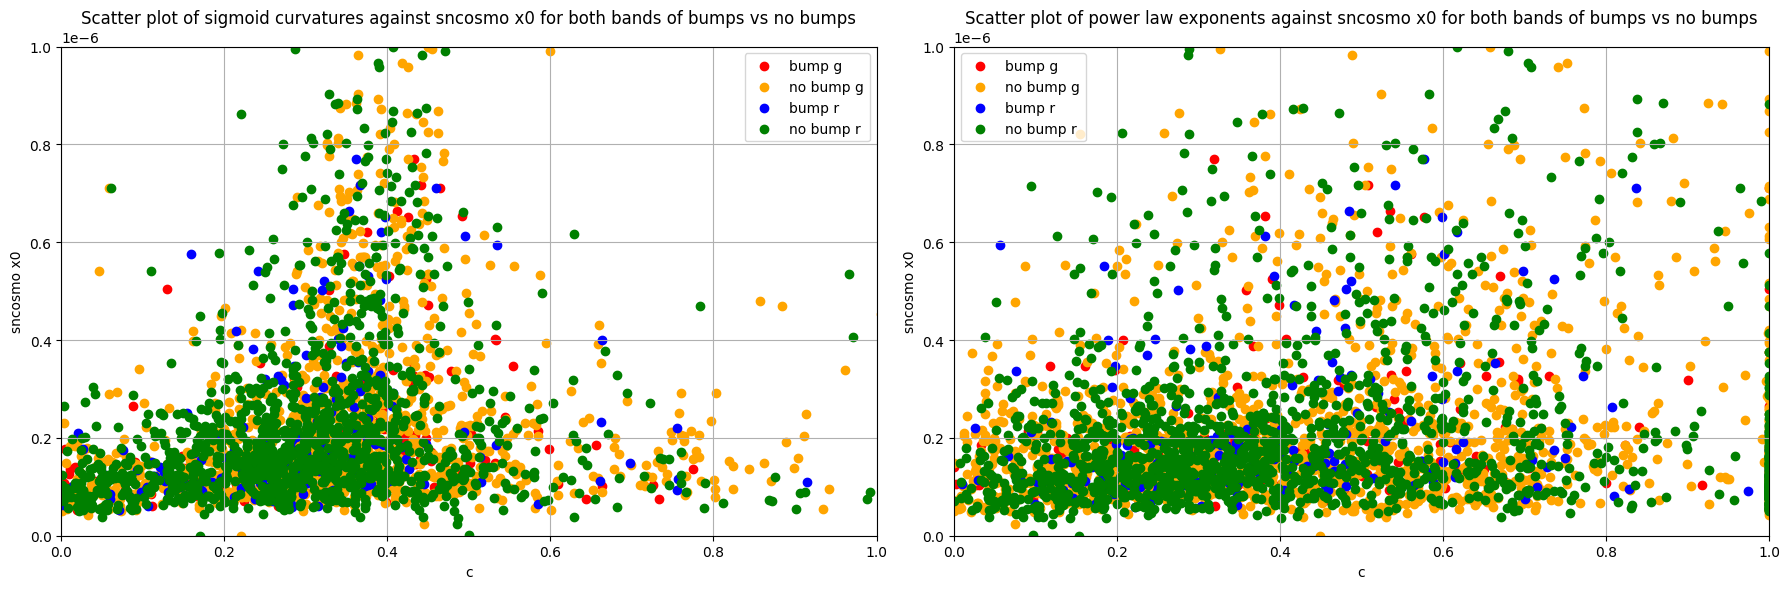

In [19]:
sig_bump_curvx0_g, sig_nb_curvx0_g, sig_bump_curvx0_r, sig_nb_curvx0_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='x0', fluxfit_col='c', 
    model_name='sigmoid'
)

sig_bump_g_x0_vals, sig_bump_g_curv_vals = sig_bump_curvx0_g['sncosmo_x0'], sig_bump_curvx0_g['fluxfit_c']
sig_nb_g_x0_vals, sig_nb_g_curv_vals = sig_nb_curvx0_g['sncosmo_x0'], sig_nb_curvx0_g['fluxfit_c']
sig_bump_r_x0_vals, sig_bump_r_curv_vals = sig_bump_curvx0_r['sncosmo_x0'], sig_bump_curvx0_r['fluxfit_c']
sig_nb_r_x0_vals, sig_nb_r_curv_vals = sig_nb_curvx0_r['sncosmo_x0'], sig_nb_curvx0_r['fluxfit_c']

sig_bump_curvx0_data = [
    [sig_bump_g_curv_vals, sig_bump_g_x0_vals, 'bump g'],
    [sig_nb_g_curv_vals, sig_nb_g_x0_vals, 'no bump g'],
    [sig_bump_r_curv_vals, sig_bump_r_x0_vals, 'bump r'],
    [sig_nb_r_curv_vals, sig_nb_r_x0_vals, 'no bump r']
]

pow_bump_curvx0_g, pow_nb_curvx0_g, pow_bump_curvx0_r, pow_nb_curvx0_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='x0', fluxfit_col='c', 
    model_name='power'
)

pow_bump_g_x0_vals, pow_bump_g_curv_vals = pow_bump_curvx0_g['sncosmo_x0'], pow_bump_curvx0_g['fluxfit_c']
pow_nb_g_x0_vals, pow_nb_g_curv_vals = pow_nb_curvx0_g['sncosmo_x0'], pow_nb_curvx0_g['fluxfit_c']
pow_bump_r_x0_vals, pow_bump_r_curv_vals = pow_bump_curvx0_r['sncosmo_x0'], pow_bump_curvx0_r['fluxfit_c']
pow_nb_r_x0_vals, pow_nb_r_curv_vals = pow_nb_curvx0_r['sncosmo_x0'], pow_nb_curvx0_r['fluxfit_c']

pow_bump_curvx0_data = [
    [pow_bump_g_curv_vals, pow_bump_g_x0_vals, 'bump g'],
    [pow_nb_g_curv_vals, pow_nb_g_x0_vals, 'no bump g'],
    [pow_bump_r_curv_vals, pow_bump_r_x0_vals, 'bump r'],
    [pow_nb_r_curv_vals, pow_nb_r_x0_vals, 'no bump r']
]

sig_title = "Scatter plot of sigmoid curvatures against sncosmo x0 for both bands of bumps vs no bumps"
pow_title = "Scatter plot of power law exponents against sncosmo x0 for both bands of bumps vs no bumps"
scatterplot_2x4_pairs(
    sig_bump_curvx0_data, pow_bump_curvx0_data, "c",  "sncosmo x0",
    titles=(sig_title, pow_title), xlims=((0, 1), (0, 1)), ylims=((0, 1e-6), (0, 1e-6))
)

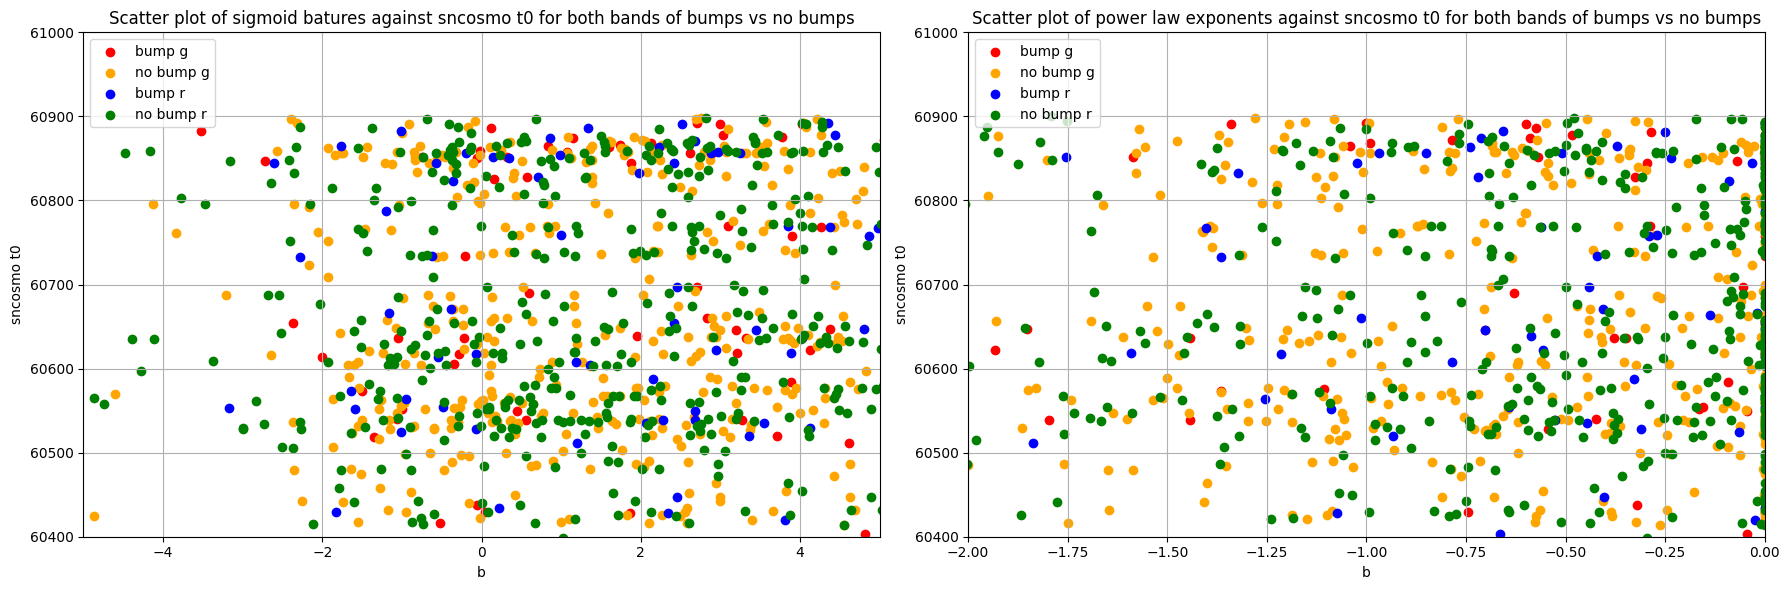

In [20]:
sig_bump_bt0_g, sig_nb_bt0_g, sig_bump_bt0_r, sig_nb_bt0_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='t0', fluxfit_col='b', 
    model_name='sigmoid'
)

sig_bump_g_t0_vals, sig_bump_g_b_vals = sig_bump_bt0_g['sncosmo_t0'], sig_bump_bt0_g['fluxfit_b']
sig_nb_g_t0_vals, sig_nb_g_b_vals = sig_nb_bt0_g['sncosmo_t0'], sig_nb_bt0_g['fluxfit_b']
sig_bump_r_t0_vals, sig_bump_r_b_vals = sig_bump_bt0_r['sncosmo_t0'], sig_bump_bt0_r['fluxfit_b']
sig_nb_r_t0_vals, sig_nb_r_b_vals = sig_nb_bt0_r['sncosmo_t0'], sig_nb_bt0_r['fluxfit_b']

sig_bump_bt0_data = [
    [sig_bump_g_b_vals, sig_bump_g_t0_vals, 'bump g'],
    [sig_nb_g_b_vals, sig_nb_g_t0_vals, 'no bump g'],
    [sig_bump_r_b_vals, sig_bump_r_t0_vals, 'bump r'],
    [sig_nb_r_b_vals, sig_nb_r_t0_vals, 'no bump r']
]

pow_bump_bt0_g, pow_nb_bt0_g, pow_bump_bt0_r, pow_nb_bt0_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='t0', fluxfit_col='b', 
    model_name='power'
)

pow_bump_g_t0_vals, pow_bump_g_b_vals = pow_bump_bt0_g['sncosmo_t0'], pow_bump_bt0_g['fluxfit_b']
pow_nb_g_t0_vals, pow_nb_g_b_vals = pow_nb_bt0_g['sncosmo_t0'], pow_nb_bt0_g['fluxfit_b']
pow_bump_r_t0_vals, pow_bump_r_b_vals = pow_bump_bt0_r['sncosmo_t0'], pow_bump_bt0_r['fluxfit_b']
pow_nb_r_t0_vals, pow_nb_r_b_vals = pow_nb_bt0_r['sncosmo_t0'], pow_nb_bt0_r['fluxfit_b']

pow_bump_bt0_data = [
    [pow_bump_g_b_vals, pow_bump_g_t0_vals, 'bump g'],
    [pow_nb_g_b_vals, pow_nb_g_t0_vals, 'no bump g'],
    [pow_bump_r_b_vals, pow_bump_r_t0_vals, 'bump r'],
    [pow_nb_r_b_vals, pow_nb_r_t0_vals, 'no bump r']
]

sig_title = "Scatter plot of sigmoid batures against sncosmo t0 for both bands of bumps vs no bumps"
pow_title = "Scatter plot of power law exponents against sncosmo t0 for both bands of bumps vs no bumps"
scatterplot_2x4_pairs(
    sig_bump_bt0_data, pow_bump_bt0_data, "b",  "sncosmo t0",
    titles=(sig_title, pow_title), xlims=((-5, 5), (-2, 0)), ylims=((60.4E3, 61E3), (60.4E3, 61E3))
)

In [21]:
sig_bump_bt0_obj_ids = [
    sig_bump_bt0_g['object id'].values,
    sig_nb_bt0_g['object id'].values,
    sig_bump_bt0_r['object id'].values,
    sig_nb_bt0_r['object id'].values
]

pow_bump_bt0_obj_ids = [
    pow_bump_bt0_g['object id'].values,
    pow_nb_bt0_g['object id'].values,
    pow_bump_bt0_r['object id'].values,
    pow_nb_bt0_r['object id'].values
]

sig_title = "sig b vs sncosmo t0"
pow_title = "pow b vs sncosmo t0"
# scatterplot_2x4_pairs_interactive(
#     sig_bump_bt0_data, pow_bump_bt0_data, sig_bump_bt0_obj_ids, pow_bump_bt0_obj_ids, "b", 
#     "sncosmo t0", titles=(sig_title, pow_title), xlims=((-5, 5), (-2, 0)), ylims=((60.4E3, 61E3), (60.4E3, 61E3))
# )

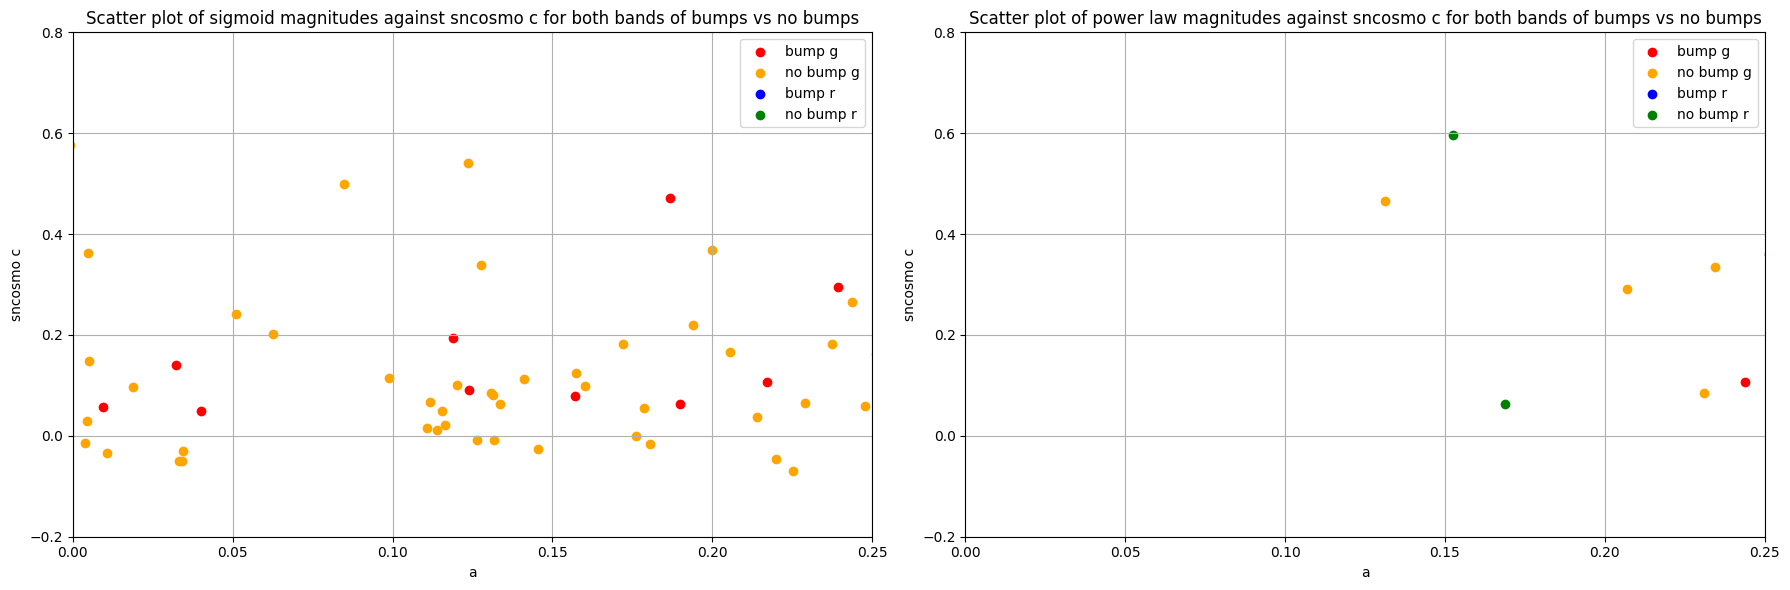

In [22]:
sig_bump_ac_g, sig_nb_ac_g, sig_bump_ac_r, sig_nb_ac_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='c', fluxfit_col='a', 
    model_name='sigmoid'
)

sig_bump_g_c_vals, sig_bump_g_a_vals = sig_bump_ac_g['sncosmo_c'], sig_bump_ac_g['fluxfit_a']
sig_nb_g_c_vals, sig_nb_g_a_vals = sig_nb_ac_g['sncosmo_c'], sig_nb_ac_g['fluxfit_a']
sig_bump_r_c_vals, sig_bump_r_b_vals = sig_bump_ac_r['sncosmo_c'], sig_bump_ac_r['fluxfit_a']
sig_nb_r_c_vals, sig_nb_r_b_vals = sig_nb_ac_r['sncosmo_c'], sig_nb_ac_r['fluxfit_a']

sig_bump_ac_data = [
    [sig_bump_g_b_vals, sig_bump_g_c_vals, 'bump g'],
    [sig_nb_g_b_vals, sig_nb_g_c_vals, 'no bump g'],
    [sig_bump_r_b_vals, sig_bump_r_c_vals, 'bump r'],
    [sig_nb_r_b_vals, sig_nb_r_c_vals, 'no bump r']
]

pow_bump_ac_g, pow_nb_ac_g, pow_bump_ac_r, pow_nb_ac_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='c', fluxfit_col='a', 
    model_name='power'
)

pow_bump_g_c_vals, pow_bump_g_a_vals = pow_bump_ac_g['sncosmo_c'], pow_bump_ac_g['fluxfit_a']
pow_nb_g_c_vals, pow_nb_g_a_vals = pow_nb_ac_g['sncosmo_c'], pow_nb_ac_g['fluxfit_a']
pow_bump_r_c_vals, pow_bump_r_b_vals = pow_bump_ac_r['sncosmo_c'], pow_bump_ac_r['fluxfit_a']
pow_nb_r_c_vals, pow_nb_r_b_vals = pow_nb_ac_r['sncosmo_c'], pow_nb_ac_r['fluxfit_a']

pow_bump_ac_data = [
    [pow_bump_g_a_vals, pow_bump_g_c_vals, 'bump g'],
    [pow_nb_g_a_vals, pow_nb_g_c_vals, 'no bump g'],
    [pow_bump_r_a_vals, pow_bump_r_c_vals, 'bump r'],
    [pow_nb_r_a_vals, pow_nb_r_c_vals, 'no bump r']
]

sig_title = "Scatter plot of sigmoid magnitudes against sncosmo c for both bands of bumps vs no bumps"
pow_title = "Scatter plot of power law magnitudes against sncosmo c for both bands of bumps vs no bumps"
scatterplot_2x4_pairs(
    sig_bump_ac_data, pow_bump_ac_data, "a",  "sncosmo c",
    titles=(sig_title, pow_title), xlims=((0, 0.25), (0, 0.25)), ylims=((-0.2, 0.8), (-0.2, 0.8))
)

In [23]:
sig_bump_ac_obj_ids = [
    sig_bump_ac_g['object id'].values,
    sig_nb_ac_g['object id'].values,
    sig_bump_ac_r['object id'].values,
    sig_nb_ac_r['object id'].values
]

pow_bump_ac_obj_ids = [
    pow_bump_ac_g['object id'].values,
    pow_nb_ac_g['object id'].values,
    pow_bump_ac_r['object id'].values,
    pow_nb_ac_r['object id'].values
]

sig_title = "sig a vs sncosmo c"
pow_title = "pow a vs sncosmo c"
# scatterplot_2x4_pairs_interactive(
#     sig_bump_ac_data, pow_bump_ac_data, sig_bump_ac_obj_ids, pow_bump_ac_obj_ids, "b", 
#     "sncosmo t0", titles=(sig_title, pow_title), xlims=((0, 0.25), (0, 0.25)), ylims=((-0.2, 0.8), (-0.2, 0.8))
# )

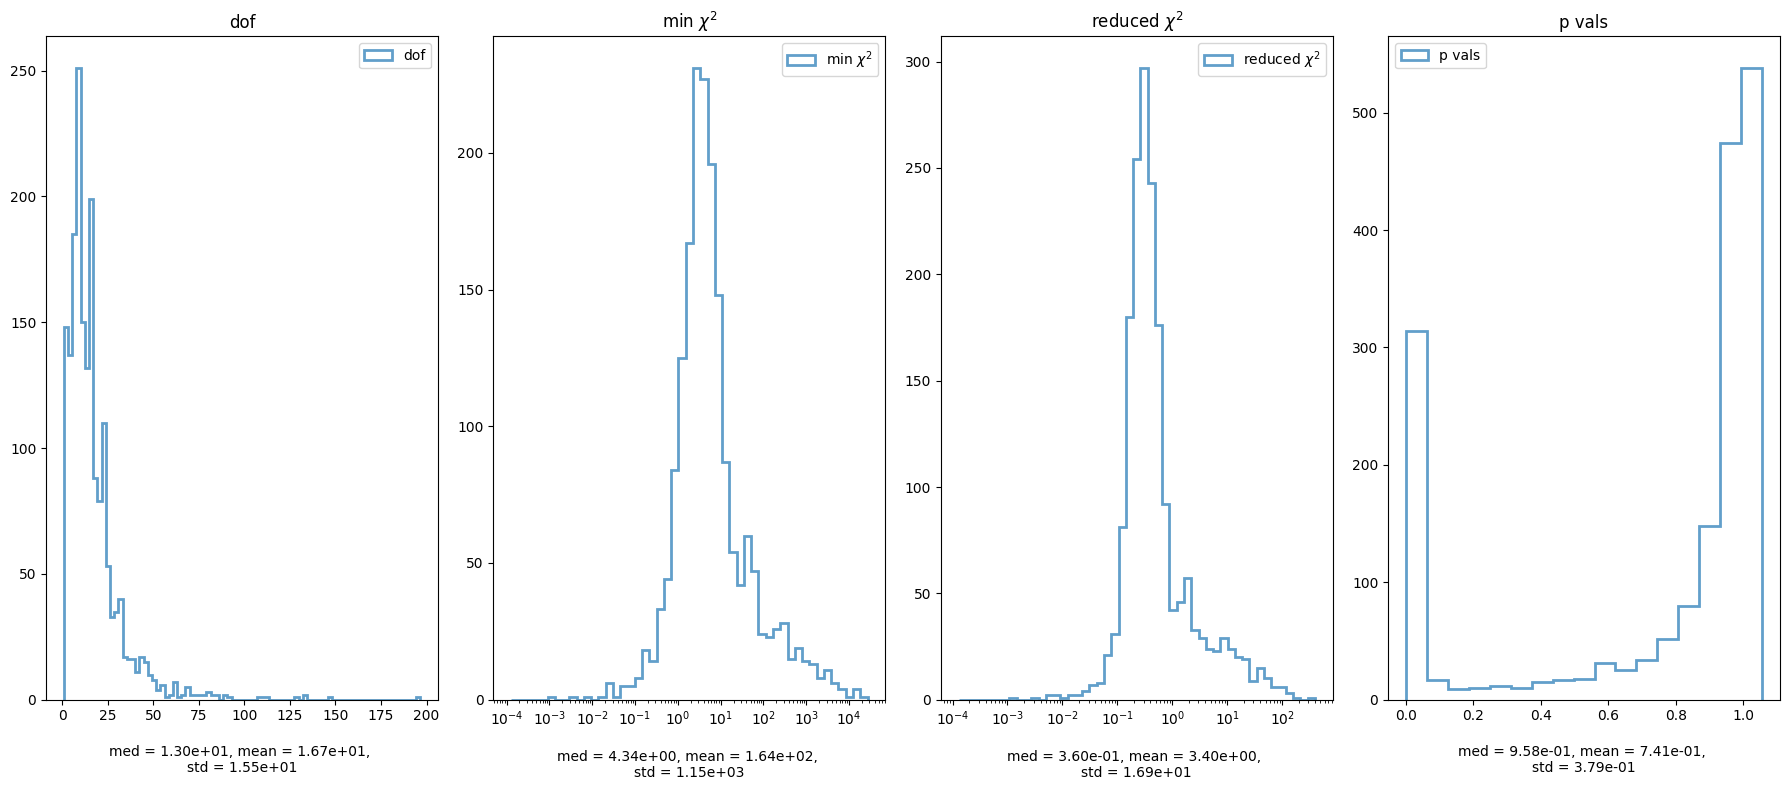

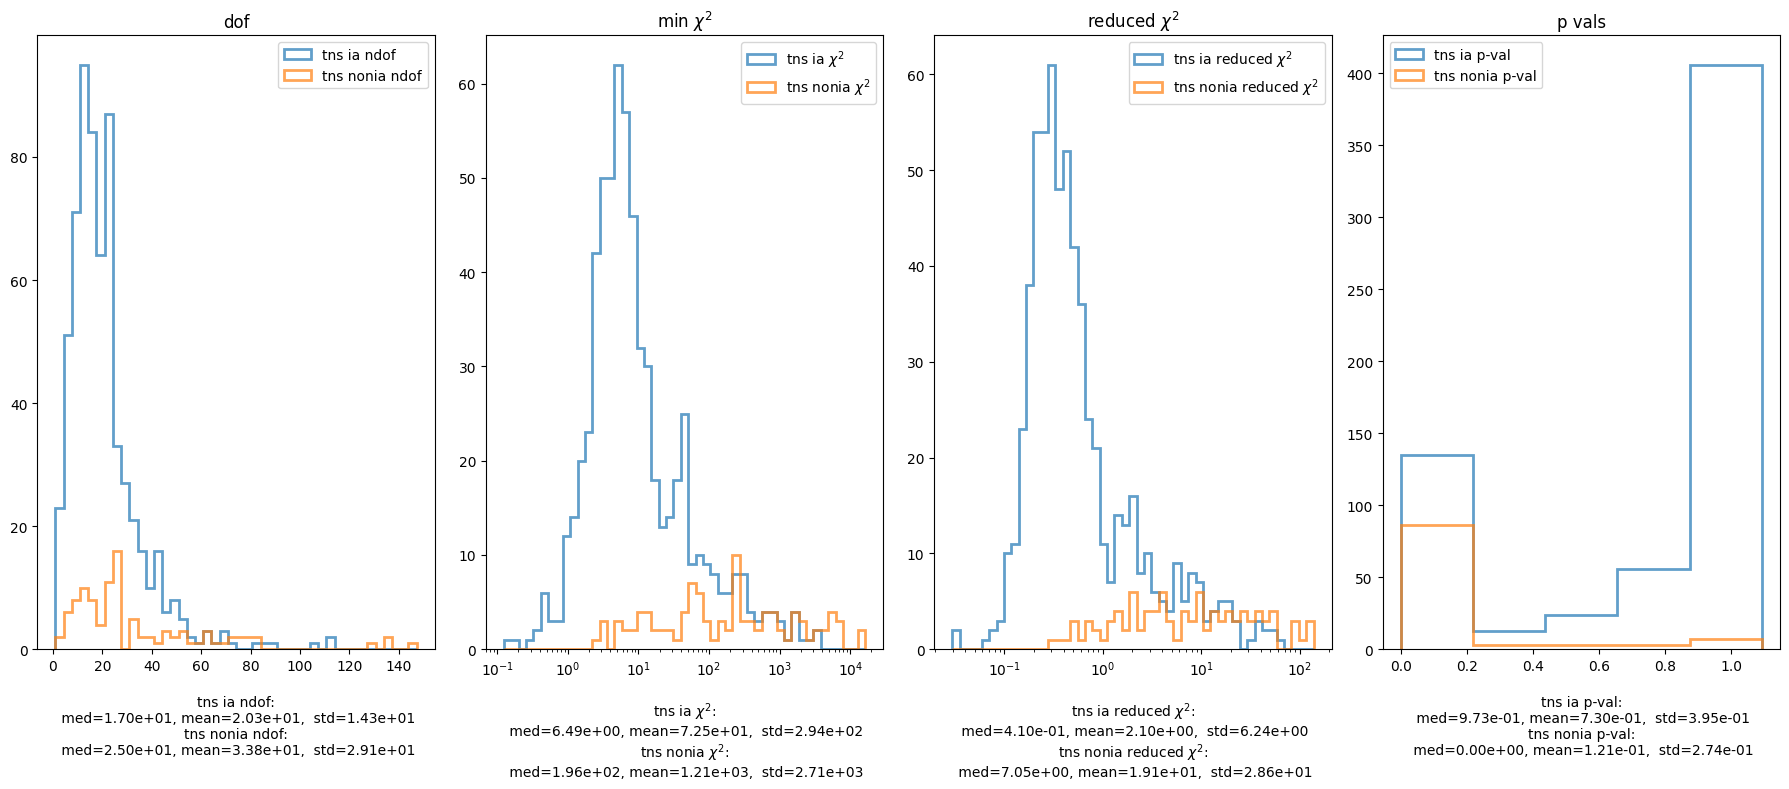

In [24]:
# Looking at distribution of evaluation metrics
ndof, min_chi2, p_vals = clean_triplets(eval_arr)
reduced_chi2 = min_chi2 / ndof

evaldata = [
    (ndof, "dof", False, False, None),
    (min_chi2, "min $\chi^2$", True, False, None),
    (reduced_chi2, "reduced $\chi^2$", True, False, None),
    (p_vals, "p vals", False, False, None)
]

plot_sncosmo_param_hist(evaldata, 18, 8, nrows=1, ncols=4)

ia_types = {'SN Ia', 'SN Ia-91T-like', 'SN Iax[02cx-like]', 'SN Ia-pec'}

merged_df = pd.merge(
    flux_fits_pdf_unique[["object id", "TNS classified"]],
    sncosmo_pdf[["object id", "ndof", "min chi2", "p-val"]],
    on="object id",
    how="inner"
)

maskTNSIa = merged_df["TNS classified"].isin(ia_types)
maskNonIaTNS = merged_df["TNS classified"].notna() & ~merged_df["TNS classified"].isin(ia_types)

merged_tnsia = merged_df[maskTNSIa]
merged_tns_nonia = merged_df[maskNonIaTNS]

tnsia_eval_arr = merged_tnsia[["ndof", "min chi2", "p-val"]].to_numpy()
tns_nonia_eval_arr = merged_tns_nonia[["ndof", "min chi2", "p-val"]].to_numpy()

tnsia_ndof, tnsia_min_chi2, tnsia_p_vals = clean_triplets(tnsia_eval_arr)
tnsia_reduced_chi2 = tnsia_min_chi2 / tnsia_ndof

tns_nonia_ndof, tns_nonia_min_chi2, tns_nonia_p_vals = clean_triplets(tns_nonia_eval_arr)
tns_nonia_reduced_chi2 = tns_nonia_min_chi2 / tns_nonia_ndof

evaldata = [
    (tnsia_ndof, tns_nonia_ndof, ["tns ia ndof", "tns nonia ndof"], "dof", False, False, None),
    (tnsia_min_chi2, tns_nonia_min_chi2, ["tns ia $\chi^2$", "tns nonia $\chi^2$"], "min $\chi^2$", True, False, None),
    (tnsia_reduced_chi2, tns_nonia_reduced_chi2, ["tns ia reduced $\chi^2$", "tns nonia reduced $\chi^2$"], "reduced $\chi^2$", True, False, None),
    (tnsia_p_vals, tns_nonia_p_vals, ["tns ia p-val", "tns nonia p-val"], "p vals", False, False, None)
]

plot_sncosmo_param_hist(evaldata, 18, 8, nrows=1, ncols=4, data_groups=True)

In [25]:
# Looking at bad tns ia fits
badTNSiaobj_id = merged_tnsia[(merged_tnsia['p-val'] < 0.2)]["object id"]
print(badTNSiaobj_id)
print(len(badTNSiaobj_id))

75      ZTF22abbausm
82      ZTF22abaqzcm
108     ZTF22abdfjjo
112     ZTF22abcknjm
148     ZTF22abfyzir
            ...     
1765    ZTF25aavdmzf
1777    ZTF25aaxjntk
1779    ZTF25aaxeojh
1785    ZTF25aaxjzzz
1817    ZTF25abadtsx
Name: object id, Length: 135, dtype: object
135


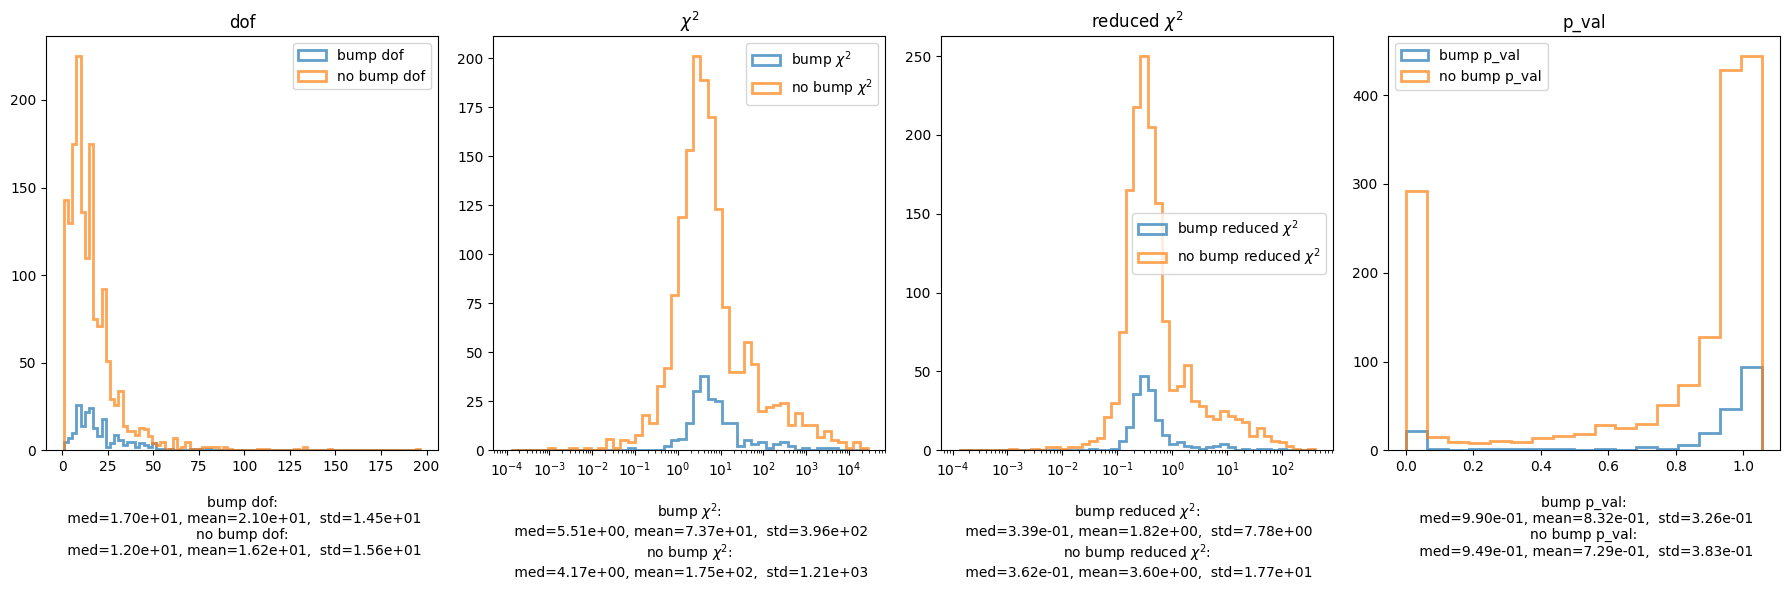

In [26]:
bump_ids = flux_fits_pdf_unique.loc[flux_fits_pdf_unique["color change"] == "bump", "object id"]

bump_sncosmo = sncosmo_pdf[sncosmo_pdf["object id"].isin(bump_ids)]
no_bump_sncosmo = sncosmo_pdf[~sncosmo_pdf["object id"].isin(bump_ids)]

bump_eval = bump_sncosmo[["ndof", "min chi2", "p-val"]].to_numpy()
bump_ndof, bump_min_chi2, bump_p_val = clean_triplets(bump_eval)
bump_red_chi2 = bump_min_chi2 / bump_ndof

no_bump_eval = no_bump_sncosmo[["ndof", "min chi2", "p-val"]].to_numpy()
nb_ndof, nb_min_chi2, nb_p_val = clean_triplets(no_bump_eval)
nb_red_chi2 = nb_min_chi2 / nb_ndof

bump_eval_pairs = [
    [bump_ndof, nb_ndof, ["bump dof", "no bump dof"], "dof", False, False, None],
    [bump_min_chi2, nb_min_chi2, ["bump $\chi^2$", "no bump $\chi^2$"], "$\chi^2$", True, False, None],
    [bump_red_chi2, nb_red_chi2, ["bump reduced $\chi^2$", "no bump reduced $\chi^2$"], "reduced $\chi^2$", True, False, None],
    [bump_p_val, nb_p_val, ["bump p_val", "no bump p_val"], "p_val", False, False, None],
]

plot_sncosmo_param_hist(bump_eval_pairs, 18, 6, data_groups=True, nrows=1, ncols=4)

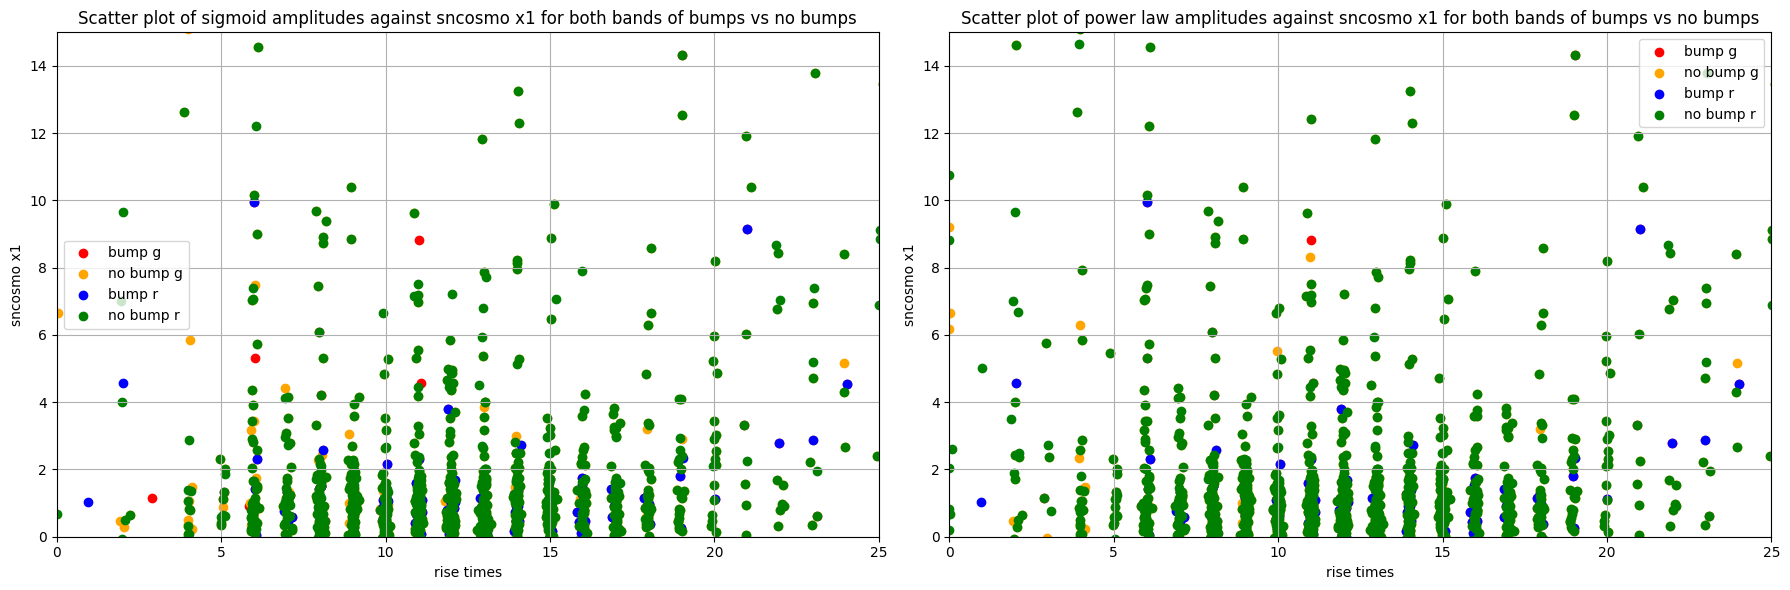

In [27]:
# Plotting rt against x1 because of shape

sig_bump_rtx1_g, sig_nb_rtx1_g, sig_bump_rtx1_r, sig_nb_rtx1_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='x1', fluxfit_col='rise_time', 
    model_name='sigmoid'
)

sig_bump_g_x1_vals, sig_bump_g_rt_vals = sig_bump_rtx1_g['sncosmo_x1'], sig_bump_rtx1_g['fluxfit_rise_time']
sig_nb_g_x1_vals, sig_nb_g_rt_vals = sig_nb_rtx1_g['sncosmo_x1'], sig_nb_rtx1_g['fluxfit_rise_time']
sig_bump_r_x1_vals, sig_bump_r_rt_vals = sig_bump_rtx1_r['sncosmo_x1'], sig_bump_rtx1_r['fluxfit_rise_time']
sig_nb_r_x1_vals, sig_nb_r_rt_vals = sig_nb_rtx1_r['sncosmo_x1'], sig_nb_rtx1_r['fluxfit_rise_time']

sig_bump_rtx1_data = [
    [sig_bump_g_rt_vals, sig_bump_g_x1_vals, 'bump g'],
    [sig_nb_g_rt_vals, sig_nb_g_x1_vals, 'no bump g'],
    [sig_bump_r_rt_vals, sig_bump_r_x1_vals, 'bump r'],
    [sig_nb_r_rt_vals, sig_nb_r_x1_vals, 'no bump r']
]

pow_bump_rtx1_g, pow_nb_rtx1_g, pow_bump_rtx1_r, pow_nb_rtx1_r = get_bump_nb_pairs(
    sncosmo_pdf, flux_fits_pdf, 
    sncosmo_col='x1', fluxfit_col='rise_time', 
    model_name='power'
)

pow_bump_g_x1_vals, pow_bump_g_rt_vals = pow_bump_rtx1_g['sncosmo_x1'], pow_bump_rtx1_g['fluxfit_rise_time']
pow_nb_g_x1_vals, pow_nb_g_rt_vals = pow_nb_rtx1_g['sncosmo_x1'], pow_nb_rtx1_g['fluxfit_rise_time']
pow_bump_r_x1_vals, pow_bump_r_rt_vals = pow_bump_rtx1_r['sncosmo_x1'], pow_bump_rtx1_r['fluxfit_rise_time']
pow_nb_r_x1_vals, pow_nb_r_rt_vals = pow_nb_rtx1_r['sncosmo_x1'], pow_nb_rtx1_r['fluxfit_rise_time']

pow_bump_rtx1_data = [
    [pow_bump_g_rt_vals, pow_bump_g_x1_vals, 'bump g'],
    [pow_nb_g_rt_vals, pow_nb_g_x1_vals, 'no bump g'],
    [pow_bump_r_rt_vals, pow_bump_r_x1_vals, 'bump r'],
    [pow_nb_r_rt_vals, pow_nb_r_x1_vals, 'no bump r']
]


sig_title = "Scatter plot of sigmoid amplitudes against sncosmo x1 for both bands of bumps vs no bumps"
pow_title = "Scatter plot of power law amplitudes against sncosmo x1 for both bands of bumps vs no bumps"
scatterplot_2x4_pairs(
    sig_bump_rtx1_data, pow_bump_rtx1_data, "rise times",  "sncosmo x1",
    titles=(sig_title, pow_title), xlims=((0, 25), (0, 25)), ylims=((0, 15), (0, 15))
)

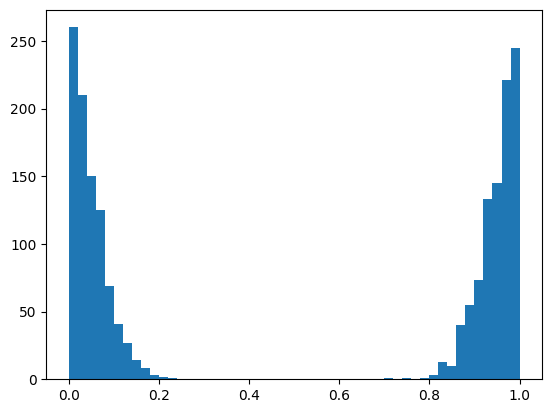

In [28]:
data = flux_fits_pdf_unique["rise_time"] - np.floor(flux_fits_pdf_unique["rise_time"])

plt.hist(data, bins=50)
plt.show()